# El Mercado Inmobiliario en Ciudad de México

En este trabajo se hará un análisis del mercado inmobiliario de la ciudad de México. Nos centraremos específicamente en el mercado de la venta de departamentos y casas habitacionales. Utilizaremos la página Lamudi para llevar a cabo el análisis. En este notebook, se llevará a cabo la adquisición de los datos. Se utilizarán las librerías requests y beautiful soup para obtener la información de Lamudi. El producto final de este cuaderno es un archivo csv con la información de las ofertas de casas y departamentos en la Ciudad de México.

## 1. Extracción de datos

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import re
import math
import scipy.stats as stats

In [2]:
headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
    'referrer': 'https://google.com',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
    'Pragma': 'no-cache'}

In [3]:
delegaciones = ['alvaro-obregon','azcapotzalco','benito-juarez','coyoacan','cuajimalpa-de-morelos','cuauhtemoc-2',
                'gustavo-a-madero','iztacalco','iztapalapa','la-magdalena-contreras','miguel-hidalgo','milpa-alta',
                'tlahuac','tlalpan','venustiano-carranza-1','xochimilco']

rangos = ['price:0-1000000','price:1000000-2000000','price:2000000-3000000','price:3000000-5000000','price:5000000-7000000',
          'price:7000000-10000000','price:10000000-15000000','price:15000000+']

rangos_bj = ['price:0-1000000','price:1000000-2000000','price:2000000-3000000','price:3000000-3500000','price:3500000-4000000',
             'price:4000000-5000000','price:5000000-7000000','price:7000000-10000000',
             'price:10000000-15000000','price:15000000+']

rangos_renta = ['price:0-40000','price:40000+']



In [13]:
def pagina_principal_delegacion(url):
    r = requests.get(url, headers = headers)
    contenido = r.content
    sopa = bs(contenido, 'html.parser')
    return sopa

In [70]:
def obtener_numero_paginas(sopa):
    try: 
        numero = int(sopa.find(class_="sorting nativeDropdown js-pagination-dropdown" )['data-pagination-end'])
        return numero
    except: 
        return 1

In [112]:
def obtener_numero_inmuebles(sopa):
    return int(sopa.find(class_="CountTitle-number").text.replace(',', ''))

In [15]:
def obtener_listado(url, pagina):
    r = requests.get(url+str(pagina), headers = headers)
    contenido = r.content
    sopa = bs(contenido, 'html.parser')
    listado = sopa.find_all(class_="ListingCell-AllInfo ListingUnit")
    return listado

In [16]:
def obtener_datos(listado):
    columnas_deseadas = ['delegacion','data-category','data-bedrooms','data-car_spaces','data-bathrooms',
                         'data-year_built','data-floor','data-building_size','data-furnished','data-geo-point',
                         'data-price']
    
    datos = pd.DataFrame(columns=columnas_deseadas)

    for departamento in listado:
        atributos = departamento.attrs
        atributos.pop('class')
        datos_propiedad = {}
        datos_propiedad_df = pd.DataFrame(atributos,index=[0])
        datos = pd.concat([datos,datos_propiedad_df], ignore_index=True)
    return datos

In [133]:
def obtener_df_delegacion(delega, tipo, operacion, rango_precio):
    columnas_deseadas = ['data-category','data-bedrooms','data-car_spaces','data-bathrooms',
                         'data-year_built','data-floor','data-building_size','data-furnished','data-geo-point',
                         'data-price']
    datos_delegacion = pd.DataFrame(columns=columnas_deseadas)
    url_principal = 'https://www.lamudi.com.mx/distrito-federal/'+delega+'/'+tipo+'/for-'+operacion+'/'+rango_precio+'/'
    sopa_principal = pagina_principal_delegacion(url_principal)
    listado_principal = sopa_principal.find_all(class_="ListingCell-AllInfo ListingUnit")
    datos_delegacion = pd.concat([datos_delegacion,obtener_datos(listado_principal)])
    numero_paginas = obtener_numero_paginas(sopa_principal)
    numero_inmuebles = obtener_numero_inmuebles(sopa_principal)
    
    url = 'https://www.lamudi.com.mx/distrito-federal/'+delega+'/'+tipo+'/for-'+operacion+'/'+rango_precio+'?page='
    for pagina in range(2,numero_paginas+1):
        listado = obtener_listado(url, pagina)
        datos = obtener_datos(listado)
        print(delega, tipo, rango_precio, operacion, pagina)
        datos_delegacion = pd.concat([datos_delegacion,datos], ignore_index=True)
    datos_delegacion['delegacion'] = delega
    datos_delegacion['rango_precio'] = rango_precio
    return datos_delegacion.iloc[0:numero_inmuebles]
       
    

In [149]:
venta = pd.DataFrame()
for delega in delegaciones:
    rangos = ['price:0-1000000','price:1000000-2000000','price:2000000-3000000','price:3000000-5000000','price:5000000-7000000',
          'price:7000000-10000000','price:10000000-15000000','price:15000000+']
    if delega == 'benito-juarez':
        rangos = rangos_bj
    for rango in rangos:
        casas = obtener_df_delegacion(delega, 'casa','sale',rango)
        departamentos = obtener_df_delegacion(delega, 'departamento','sale', rango)
        venta = pd.concat([venta, casas, departamentos], ignore_index=True)
        
renta = pd.DataFrame()
for delega in delegaciones:
    for rango in rangos_renta:
        casas = obtener_df_delegacion(delega, 'casa','rent',rango)
        departamentos = obtener_df_delegacion(delega, 'departamento','rent',rango)
        renta = pd.concat([renta, casas, departamentos], ignore_index=True)

In [148]:
renta.to_csv('renta_raw.csv')
venta.to_csv('venta_raw.csv')

## 2. Limpieza de datos 

### 2.1 Eliminación de columnas que no se usarán

Primero, observaremos los conjuntos de datos para darnos una idea de cómo se ven.

In [42]:
venta_1 = pd.read_csv('venta_raw.csv', index_col = 0)
renta_1 = pd.read_csv('renta_raw.csv', index_col = 0)

In [43]:
venta_1.head(1)

,data-category,data-bedrooms,data-car_spaces,data-bathrooms,data-year_built,data-floor,data-building_size,data-furnished,data-geo-point,data-price,...,data-land_size,data-sku,data-listing-top-position,data-rooms_total,rango_precio,data-price_conditions,data-mantenimiento,data-floors_total,data-listing-new-development,data-deposit
0,casa,5.0,3.0,4.0,NaN,NaN,450.0,36,"[-99.20628,19.32237]",916259.0,...,450.0,HO639B5E40268DAMX,True,NaN,price:0-1000000,NaN,NaN,NaN,NaN,NaN


Ahora, extraeremos solamente las columnas que nos interesan y serán útiles para el análisis. Eliminaremos las columnas que son mayormente datos faltantes. Además, haremos que las columnas sean iguales en ambos dataframes para poder integrarlos en uno solo y facilitar la limpieza.

In [44]:
renta_2 = renta_1.drop(['data-subcategories', 'data-mantenimiento', 'data-deposit','data-price_conditions', 
                        'data-floors_total', 'data-furnished', 'data-rooms_total', 'data-listing-top-position'], axis=1)
venta_2 = venta_1.drop(['data-subcategories', 'data-mantenimiento', 'data-price_conditions', 
                        'data-floors_total', 'data-furnished', 'data-rooms_total', 'data-listing-new-development',
                       'data-deposit', 'data-listing-top-position'], axis=1)

renta_2['operacion'] = 'renta'
venta_2['operacion'] = 'venta'

### 2.2 Unión de ambos dataframes en uno

In [45]:
datos_1 = pd.concat([renta_2, venta_2], axis = 0, ignore_index=True)

In [46]:
datos_1.head(1)

,data-category,data-bedrooms,data-car_spaces,data-bathrooms,data-year_built,data-floor,data-building_size,data-geo-point,data-price,delegacion,data-land_size,data-sku,rango_precio,operacion
0,casa,3.0,3.0,2.5,NaN,NaN,200.0,"[-99.19955,19.33658]",35000.0,alvaro-obregon,200.0,HO638A4AD5DE8AFMX,price:0-40000,renta


### 2.3 Renombramiento de columnas

In [47]:
columnas = list(datos_1.columns)
nuevas_columnas = [columna.lstrip('data-') for columna in columnas]
nuevas_dict = {columnas[i]:nuevas_columnas[i] for i in range(len(columnas))}

datos_2 = datos_1.rename(columns=nuevas_dict).rename(columns={'elegacion':'delegacion'})

### 2.4 Primera eliminación de valores faltantes

Ahora, necesitamos hacernos cargo de los valores faltantes. A continuación revisamos cuántos hay en cada columna.

In [48]:
datos_2.isna().sum()

category             0
bedrooms            20
car_spaces          85
bathrooms           17
year_built       38060
floor            36114
building_size        1
geo-point           69
price                0
delegacion           0
land_size        65185
sku                  0
rango_precio         0
operacion            0
dtype: int64

Debido a que necesitamos la ubicación del inmueble para nuestro análisis, nos desharemos de las filas que no tengan información en la ubicación. También, consideramos que no existe una razón evidente para que falten los datos en las columnas bedrooms, car spaces, bathrooms y building size. Además, el número de observaciones que tienen datos faltantes para cada una de esas variables es muy bajo.

In [49]:
datos_2.dropna(subset=['geo-point','bedrooms', 'car_spaces', 'bathrooms'], inplace=True)

In [50]:
datos_2.isna().sum()

category             0
bedrooms             0
car_spaces           0
bathrooms            0
year_built       37959
floor            36052
building_size        0
geo-point            0
price                0
delegacion           0
land_size        65113
sku                  0
rango_precio         0
operacion            0
dtype: int64

Ahora, revisaremos las columnas que aún tienen valores faltantes. Debido a que tienen una cantidad bastante grande de valores faltantes y son variables que consideramos importantes para el análisis, buscaremos una manera de imputar. Primero, le daremos el estilo deseado a los gráficos.

In [51]:
sns.set_style('dark')
sns.set_style(rc={'figure.facecolor':'#404258', 'axes.facecolor':'lightgrey'})
plt.rcParams["legend.labelcolor"] = '#F0E9E9'
plt.rcParams['axes.labelcolor']='#F0E9E9'
plt.rcParams['xtick.labelcolor']='#F0E9E9'
plt.rcParams['ytick.labelcolor']='#F0E9E9'
plt.rcParams['axes.titlecolor']='#F0E9E9'
plt.rcParams['legend.facecolor']='#404258'
plt.rcParams['legend.edgecolor']='#404258'
plt.rcParams['figure.dpi']='100'

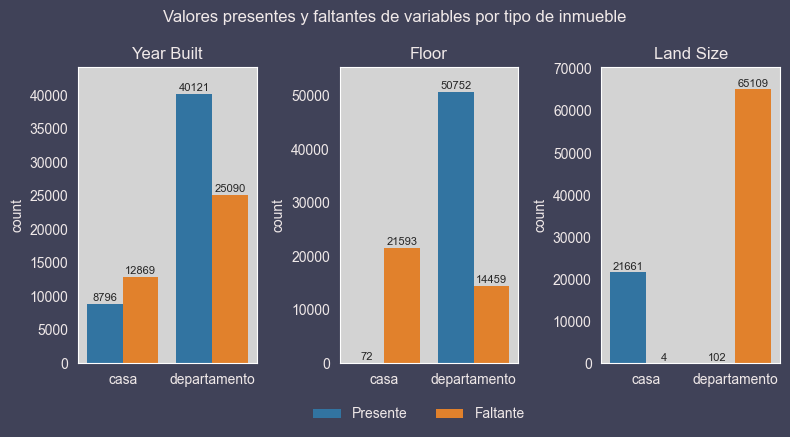

In [52]:
fig, ax = plt.subplots(1,3,figsize=(8,4))
variables = ['year_built', 'floor', 'land_size']
nombres = ['Year Built', 'Floor', 'Land Size']
coordinates = [-.2,0.2,0.8,1.2]

for i in range(3):
    sns.countplot(hue=datos_2[variables[i]].isna(), x=datos_2.category, ax=ax[i], linewidth = 0)
    ax[i].set_title(nombres[i])
    ax[i].get_legend().remove()
    ax[i].set_ylim(top=ax[i].get_ylim()[1]+2000)
    ax[i].set_xlabel('')
    order = [0,2,1,3]
    patches = [p.get_height() for p in ax[i].patches]
    heights = [patches[j] for j in order]
    for k in range(4):
        ax[i].annotate(round(heights[k],0), xy=(coordinates[k],heights[k]+500),horizontalalignment='center', fontsize=8)


fig.legend(['Presente', 'Faltante'], loc='lower center',bbox_to_anchor=(0.53,-0.08), ncol=2, )
plt.suptitle('Valores presentes y faltantes de variables por tipo de inmueble', color='#F0E9E9')
plt.tight_layout()
plt.show()

Vemos que la mayoría de las casas tienen valor faltante para el año en que se construyeron, mientras que en los departamentos es más común que sí se registre el año de construcción. Por otra parte, como se esperaba, casi todas las casas tienen valor faltante para la variable piso, pero hay 72 casas para las que sí se registró un valor, mientras la mayoría de los departamentos sí registran esta variable. Finalmente, como se esperaba, landsize es una variable que tienen las casas y que le falta a los departamentos. Aun así, hay 4 casas sin landsize y 102 departamentos con landsize.

A continuación, quitaremos los datos de floor para las casas y de landsize para los departamentos. Asimismo, quitaremos los registros de las 4 casas que no tienen información para landsize.

In [53]:
datos_3 = datos_2.copy()
datos_3.loc[datos_3.category == 'casa','land_size'] = datos_3.loc[datos_3.category == 'casa'].dropna(subset = ['land_size']).land_size

In [54]:
datos_3.loc[(datos_3.category == 'departamento')&(datos_3.land_size.isna()==False),'land_size'] = np.nan

In [55]:
datos_3.loc[(datos_3.category == 'casa')&(datos_3.floor.isna()==False),'floor'] = np.nan

In [56]:
datos_3.isna().sum()

category             0
bedrooms             0
car_spaces           0
bathrooms            0
year_built       37959
floor            36124
building_size        0
geo-point            0
price                0
delegacion           0
land_size        65215
sku                  0
rango_precio         0
operacion            0
dtype: int64

### 2.5 Corrección de tipos de datos

Primero, crearemos dos nuevas columnas en las que separaremos la columna geo-point: longitud y latitud.

In [57]:
datos_4 = datos_3.copy()
datos_4[['longitud','latitud']]=datos_4['geo-point'].str.strip('[]').str.split(',', expand=True)
datos_4.drop(columns=['geo-point'], inplace=True)

In [58]:
datos_4.head(3)

,category,bedrooms,car_spaces,bathrooms,year_built,floor,building_size,price,delegacion,land_size,sku,rango_precio,operacion,longitud,latitud
0,casa,3.0,3.0,2.5,NaN,NaN,200.0,35000.0,alvaro-obregon,200.0,HO638A4AD5DE8AFMX,price:0-40000,renta,-99.19955,19.33658
1,casa,3.0,2.0,3.5,NaN,NaN,185.0,27000.0,alvaro-obregon,240.0,HO5AEC90C0DD833MX,price:0-40000,renta,-99.22136678,19.38860655
2,casa,3.0,2.0,2.0,NaN,NaN,200.0,21500.0,alvaro-obregon,100.0,HO5FD4379EC2365MX,price:0-40000,renta,-99.22132,19.3376


Ahora, revisaremos que las columnas que deberían tener tipo de dato numérico, lo tengan.

In [59]:
datos_4.dtypes

category          object
bedrooms         float64
car_spaces       float64
bathrooms        float64
year_built       float64
floor             object
building_size    float64
price            float64
delegacion        object
land_size        float64
sku               object
rango_precio      object
operacion         object
longitud          object
latitud           object
dtype: object

In [60]:
datos_4.loc[:,'longitud'] = pd.to_numeric(datos_4.longitud)
datos_4.loc[:,'latitud'] = pd.to_numeric(datos_4.latitud)

La columna floor debería ser numérica pero tiene datos en letra, entonces ahora la limpiaremos. Definiremos una función que nos ayude a transformar los datos de string en float, utilizando filtros de texto.

In [61]:
def obtener_piso(piso_original):
    pisos_letra = ['pb|planta|p\.b|baj','uno|prim', 'dos|segu', 'terc|tres', 'cuart|cuatr', 'quin|cinc|PH|p.h|pent|azot|últ','sex|sei', 'sép|sep|siet',
                  'oct|och', 'nov', 'X']
    pisos_numero = [0,1,2,3,4,5,6,7,8,9, 10]
    
    revisar = {pisos_letra[i]:pisos_numero[i] for i in range(len(pisos_letra))}
    try:
        float(piso_original)
        return float(piso_original)
    
    except: 
        if len(re.findall('\d+',piso_original)) != 0:
            return int(re.findall('\d+',piso_original)[0])
        
        else:
            for piso in revisar:
                if len(re.findall(re.compile(piso, re.I),piso_original))!= 0:
                    return revisar[piso]
        return np.nan
                
        

In [62]:
datos_4.loc[:,'floor'] = datos_4.floor.apply(obtener_piso)

### 2.6 Revisión de divisas de precios

In [63]:
datos_5 = datos_4.copy()

Debemos revisar si los precios están en pesos mexicanos o en dólares americanos. Para hacer esto, usaremos la columna rango precio que generamos cuando adquirimos los datos. Compararemos la columna price con la columna rango precio. Si price vale alrededor de un veinteavo de lo que vale rango, sabremos que la divisa es el dólar. Definiremos una función.

In [64]:
def obtener_divisa(row):
    rango = row.rango_precio
    precio = row.price
    if not '-' in rango:
        rango_num = int(re.sub(r'[^0-9]', '', rango))
        if precio >= rango_num:
            return 'MXN'
        return 'USD'
    else:
        rango_separado = rango.lstrip('price:').split('-')
        rango_inf = int(rango_separado[0])
        rango_sup = int(rango_separado[1])
        if (precio >= rango_inf) & (precio<=rango_sup):
            return 'MXN'
        return 'USD'
    
    

In [65]:
datos_5['divisa'] = datos_5.apply(obtener_divisa, axis=1)

Ahora, cambiaremos la columna price para que refleje el precio en pesos mexicanos, conservando la información sobre si el precio estaba publicado en pesos o en dólares.

In [66]:
tipo_cambio = 19.40
datos_5.loc[:,'price'] = datos_5.apply(lambda row: row.price*tipo_cambio if row.divisa == 'USD' else row.price, axis=1)

In [67]:
datos_5.head()

,category,bedrooms,car_spaces,bathrooms,year_built,floor,building_size,price,delegacion,land_size,sku,rango_precio,operacion,longitud,latitud,divisa
0,casa,3.0,3.0,2.5,NaN,NaN,200.0,35000.0,alvaro-obregon,200.0,HO638A4AD5DE8AFMX,price:0-40000,renta,-99.199550,19.336580,MXN
1,casa,3.0,2.0,3.5,NaN,NaN,185.0,27000.0,alvaro-obregon,240.0,HO5AEC90C0DD833MX,price:0-40000,renta,-99.221367,19.388607,MXN
2,casa,3.0,2.0,2.0,NaN,NaN,200.0,21500.0,alvaro-obregon,100.0,HO5FD4379EC2365MX,price:0-40000,renta,-99.221320,19.337600,MXN
3,casa,3.0,2.0,2.0,NaN,NaN,200.0,21500.0,alvaro-obregon,100.0,HO6366A503A278DMX,price:0-40000,renta,-99.221320,19.337600,MXN
4,casa,4.0,4.0,5.0,NaN,NaN,295.0,25000.0,alvaro-obregon,218.0,HO637469CA3C86BMX,price:0-40000,renta,-99.252870,19.343270,MXN


Ahora tenemos todas las columnas con el tipo de datos deseado. Por tanto, podemos proseguir con la detección y tratamiento de valores atípicos.

## 3. Valores atípicos

### 3.1 Bedrooms

In [68]:
datos_6 = datos_5.copy()

In [69]:
datos_6.bedrooms.describe()

count    86876.000000
mean         2.614819
std          3.153396
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        682.000000
Name: bedrooms, dtype: float64

(-1.0, 10.0)

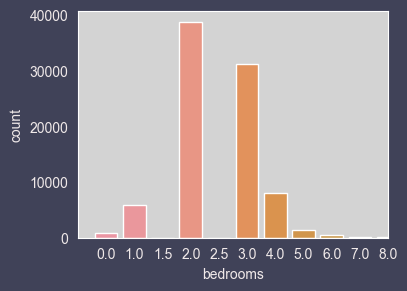

In [70]:
fig, ax = plt.subplots(figsize=(4,3))
sns.countplot(x=datos_6.bedrooms, ax=ax)
plt.xlim(-1,10)

Vemos que hay algunas propiedades que tienen valores no enteros para el número de cuartos. Lo que haremos es reducir el número al entero más cercano. Las propiedades con cero cuartos las dejaremos y consideraremos que son lofts. 

In [71]:
datos_6.loc[:,'bedrooms'] = datos_6.bedrooms.apply(math.floor)

(0.0, 45000.0)

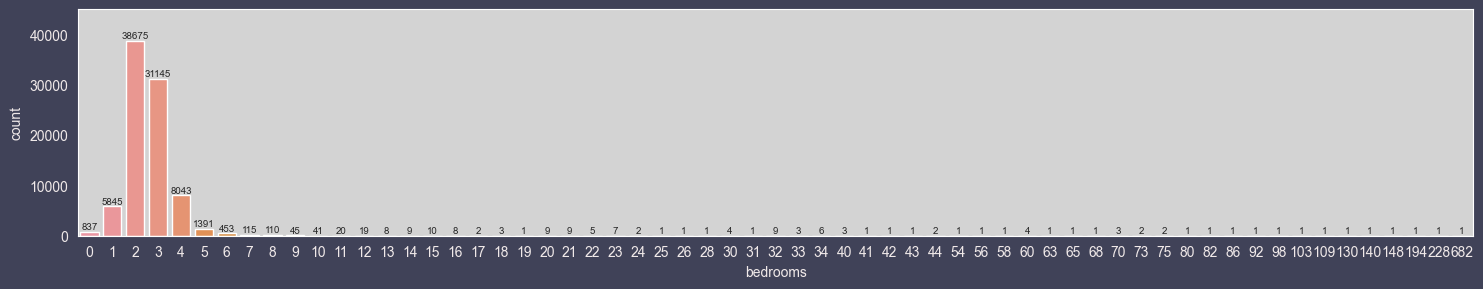

In [72]:
fig, ax = plt.subplots(figsize=(18,3))
sns.countplot(x=datos_6.bedrooms, ax=ax)
patches = [p.get_height() for p in ax.patches]
x_coord = [patch.get_x() for patch in ax.patches]
for k in range(len(patches)):
    ax.annotate(round(patches[k],0), xy=(x_coord[k]+0.4,patches[k]+500),horizontalalignment='center', fontsize=7)
plt.ylim(0,45000)

(-1.0, 50.0)

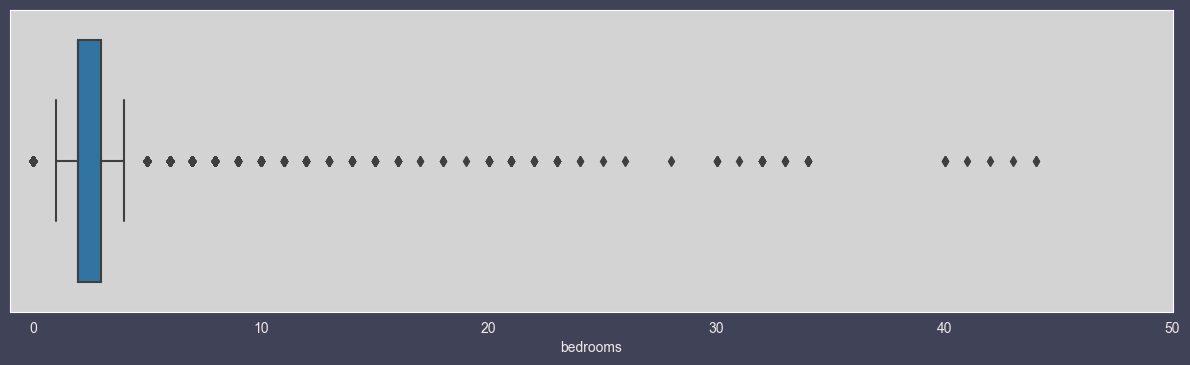

In [73]:
fig, ax = plt.subplots(figsize=(15,4))
sns.boxplot(x=datos_6.bedrooms)
plt.xlim(-1,50)

Si bien el boxplot detecta que todos los valores iguales a cinco o mayores son datos atípicos, sabemos que no es imposible que un inmueble cuente con cinco cuartos y que esto podría ser la variación natural de la variable. Sin embargo, hay valores que resultan claramente datos atípicos, como un inmueble con 25 cuartos. En este caso, dado que se sospecha que los inmuebles con muchos cuartos son resultado de un error en la información del sitio, consideraremos que los valores que estén dentro de tres desviaciones estandar de la media serán datos válidos. Por tanto:

In [74]:
bedrooms_mean = datos_6.bedrooms.mean()
bedrooms_std = datos_6.bedrooms.std()

In [75]:
max_lim = round(bedrooms_mean + 3*bedrooms_std, 0)

In [76]:
max_lim

12.0

In [77]:
len(datos_6.bedrooms[datos_6.bedrooms>max_lim])

137

Por tanto, consideraremos que los inmuebles con 12 o menos cuartos son datos válidos. El resto de los datos serán eliminados, considerando que solamente son 137. Consideramos que esto es adecuado, también, basándonos en el conocimiento que tenemos por observación de los inmuebles en la ciudad. Hay casas extremadamente amplias, pero creemos que ni siquiera esas tendrían más de 12 cuartos.

In [78]:
datos_7 = datos_6[datos_6.bedrooms<=12]

In [79]:
datos_7.bedrooms.describe()

count    86739.000000
mean         2.552750
std          0.966115
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: bedrooms, dtype: float64

(0.0, 45000.0)

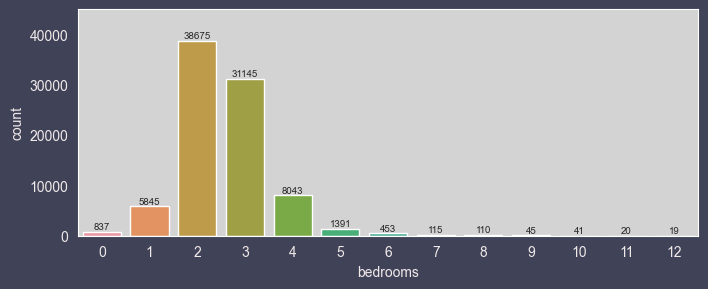

In [80]:
fig, ax = plt.subplots(figsize=(8,3))
sns.countplot(x=datos_7.bedrooms, ax=ax)
patches = [p.get_height() for p in ax.patches]
x_coord = [patch.get_x() for patch in ax.patches]
for k in range(len(patches)):
    ax.annotate(round(patches[k],0), xy=(x_coord[k]+0.4,patches[k]+500),horizontalalignment='center', fontsize=7)
plt.ylim(0,45000)

Así, consideraremos que nuestra variable bedrooms ya está limpia y lista para ser analizada.

### 3.2 Car Spaces

Ahora, analizaremos la variable car spaces de una manera similar a la que usamos para bedrooms.

In [81]:
cars = datos_7.car_spaces.astype('int')
cars.describe()

count    86739.000000
mean         1.851013
std          9.505220
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2110.000000
Name: car_spaces, dtype: float64

Vemos que tenemos un claro problema de outliers, dado que el máximo de la variable es 2110, lo cual claramente es imposible.

<AxesSubplot:xlabel='car_spaces'>

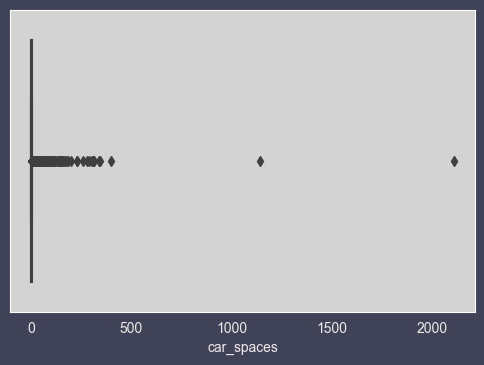

In [82]:
sns.boxplot(x=cars)

En primera instancia, sabemos que podemos eliminar los valores mayores que 1000. Esto facilitará las visualizaciones.

In [83]:
datos_8 = datos_7.copy()
datos_8 = datos_8[datos_8.car_spaces<1000]

<AxesSubplot:xlabel='car_spaces'>

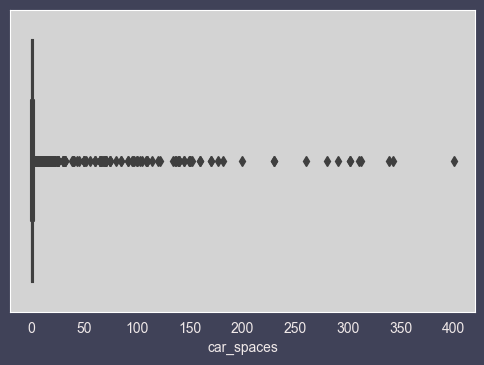

In [84]:
sns.boxplot(x=datos_8.car_spaces)

Sigue siendo complicado saber cuáles de estos datos sí son válidos y cuáles son resultado de un error en los datos de la página. Consideraremos, ahora, que 100 es el valor máximo, lo cual suena bastante razonable conociendo cómo se ven las propiedades de la ciudad.

In [85]:
datos_8 = datos_8[datos_8.car_spaces<100]

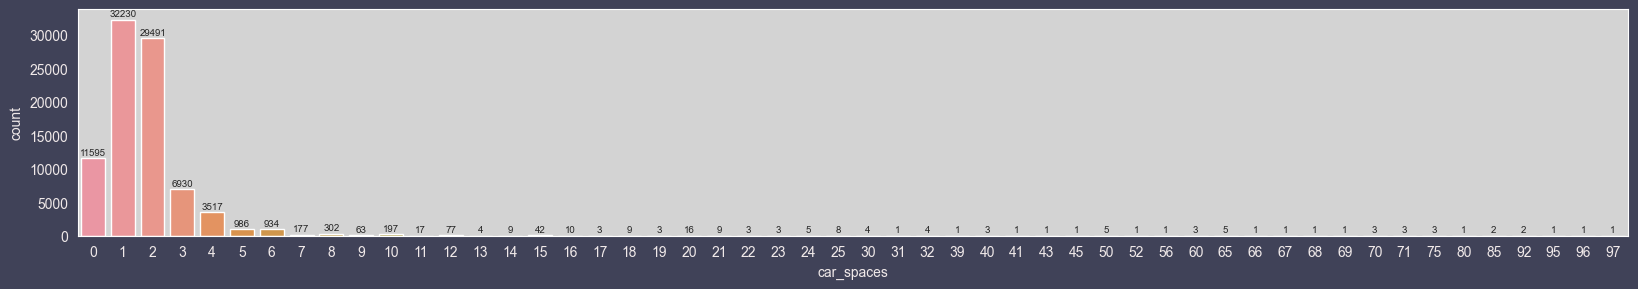

In [86]:
fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(x=datos_8.car_spaces, ax=ax)
patches = [p.get_height() for p in ax.patches]
x_coord = [patch.get_x() for patch in ax.patches]
for k in range(len(patches)):
    ax.annotate(round(patches[k],0), xy=(x_coord[k]+0.4,patches[k]+500),horizontalalignment='center', fontsize=7)

ax.set_xticklabels([str(int(float(i))) for i in [k.get_text() for k in ax.get_xticklabels()]])
plt.show()

In [87]:
datos_8.car_spaces.describe()

count    86692.000000
mean         1.720793
std          2.088443
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         97.000000
Name: car_spaces, dtype: float64

En este caso, volveremos a tomar en cuenta como valores naturales de la variable solo a los que se encuentren dentro de 3 desviaciones estándar de la media.

In [88]:
max_limit = round(datos_8.car_spaces.mean()+3*datos_8.car_spaces.std())

In [89]:
max_limit

8

In [90]:
datos_9 = datos_8.copy()
datos_9 = datos_9[datos_9.car_spaces <= 8]
datos_9['car_spaces'] = datos_9.car_spaces.astype('int')

(0.0, 40000.0)

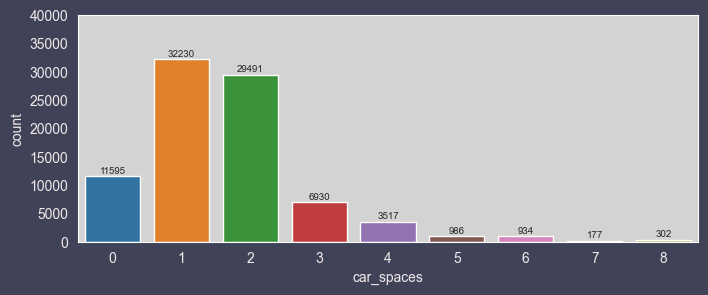

In [91]:
fig, ax = plt.subplots(figsize=(8,3))
sns.countplot(x=datos_9.car_spaces, ax=ax)
patches = [p.get_height() for p in ax.patches]
x_coord = [patch.get_x() for patch in ax.patches]
for k in range(len(patches)):
    ax.annotate(round(patches[k],0), xy=(x_coord[k]+0.4,patches[k]+500),horizontalalignment='center', fontsize=7)
plt.ylim(0,40000)

### 3.3 Bathrooms

In [92]:
datos_9.bathrooms.describe()

count    86162.000000
mean         2.167527
std          2.249317
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        332.000000
Name: bathrooms, dtype: float64

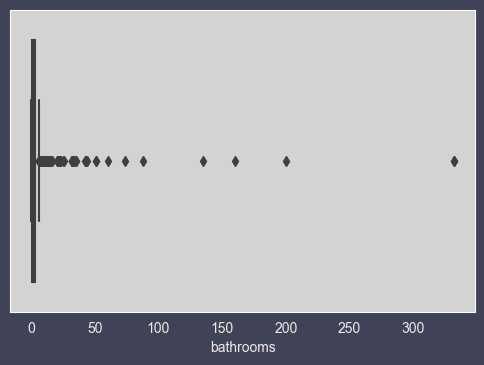

In [93]:
sns.boxplot(x=datos_9.bathrooms)
plt.show()

Primero, podemos eliminar los datos con más de 50 baños con bastante seguridad, dado que resulta imposible que haya una propiedad con esa cantidad de baños. Esto además facilitará la visualización.

In [94]:
datos_9 = datos_9[datos_9.bathrooms<50]

<AxesSubplot:xlabel='bathrooms'>

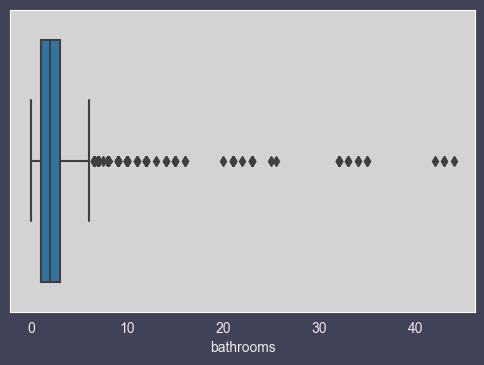

In [95]:
sns.boxplot(x=datos_9.bathrooms)

(0.0, 40000.0)

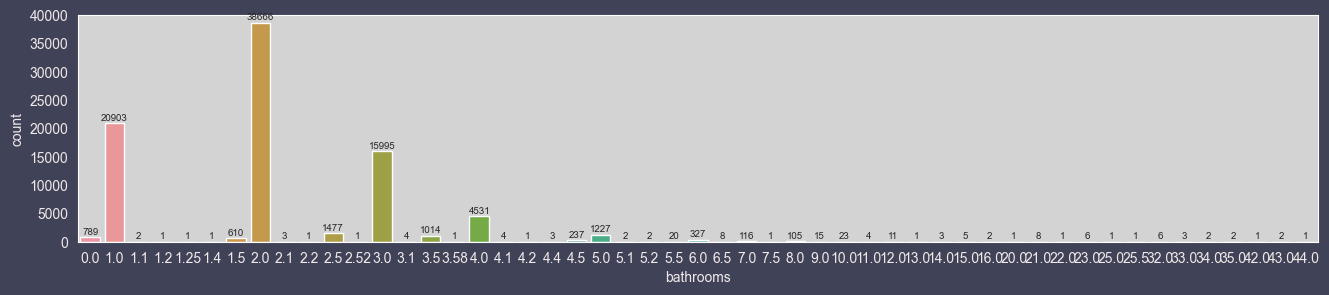

In [96]:
fig, ax = plt.subplots(figsize=(16,3))
sns.countplot(x=datos_9.bathrooms, ax=ax)
patches = [p.get_height() for p in ax.patches]
x_coord = [patch.get_x() for patch in ax.patches]
for k in range(len(patches)):
    ax.annotate(round(patches[k],0), xy=(x_coord[k]+0.4,patches[k]+500),horizontalalignment='center', fontsize=7)
plt.ylim(0,40000)

Notamos que hay un problema. Hay inmuebles que tienen registrados datos que no son enteros o enteros más un medio. Por tanto, redondearemos hacia abajo, hasta el 0.5 más cercano.

In [97]:
datos_9['bathrooms'] = datos_9.bathrooms.apply(lambda x : math.floor(x*2)/2)

(0.0, 40000.0)

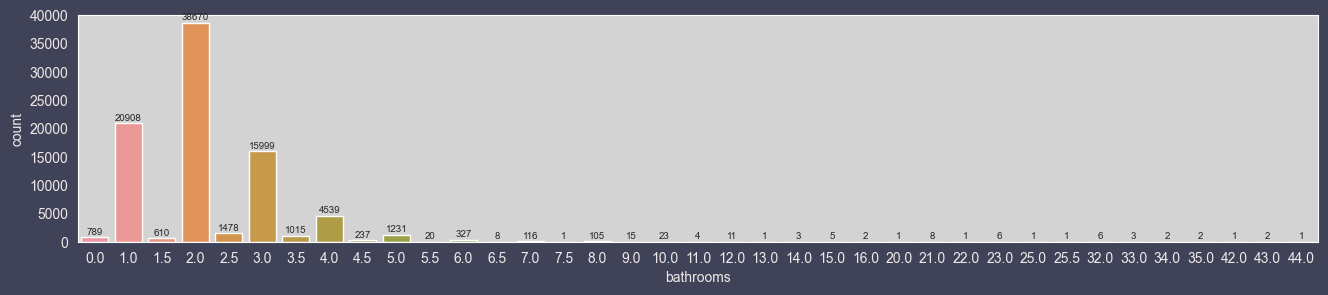

In [98]:
fig, ax = plt.subplots(figsize=(16,3))
sns.countplot(x=datos_9.bathrooms, ax=ax)
patches = [p.get_height() for p in ax.patches]
x_coord = [patch.get_x() for patch in ax.patches]
for k in range(len(patches)):
    ax.annotate(round(patches[k],0), xy=(x_coord[k]+0.4,patches[k]+500),horizontalalignment='center', fontsize=7)
plt.ylim(0,40000)

Ahora, usaremos el mismo principio que usamos para las otras variables: Tomaremos como outlier a los datos que se encuentren a más de tres desviaciones estandar de la media.

In [99]:
lim_max = round(datos_9.bathrooms.mean()+3*datos_9.bathrooms.std())
lim_max

6

Sin embargo, consideramos que las casas con 7 u 8 baños no son imposibles, por lo cual, en este caso tomaremos esos inmuebles y cambiaremos su número de baños a 6 para mantenerlas en el conjunto de datos.

In [100]:
datos_9['bathrooms'] = datos_9.bathrooms.apply(lambda x : 6.0 if ((x==7.0) | (x==8.0)) else x)
datos_9 = datos_9[datos_9.bathrooms <= 6]

### 3.4 Year built

En este caso será más sencillo detectar cuáles son datos erróneos, considerando que conocemos el contexto de la ciudad.

In [101]:
datos_10 = datos_9.copy()

<AxesSubplot:xlabel='year_built'>

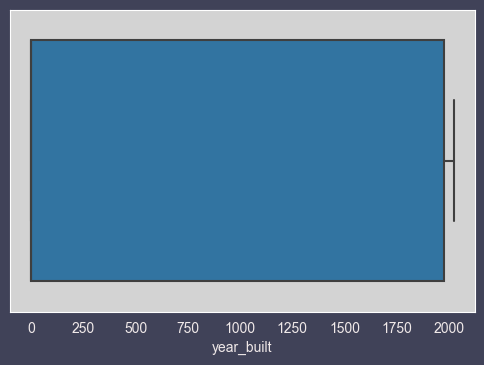

In [102]:
sns.boxplot(x=datos_10.year_built)

<AxesSubplot:xlabel='year_built', ylabel='Count'>

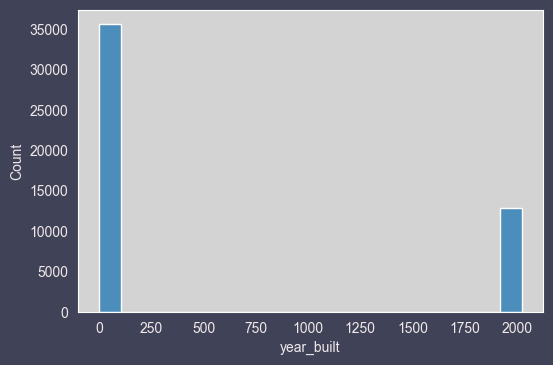

In [103]:
sns.histplot(x=datos_10.year_built)

In [104]:
datos_10[datos_10.category=='departamento'].year_built.value_counts(normalize=True)

0.0       0.745989
2022.0    0.026025
2021.0    0.016418
2019.0    0.014896
2020.0    0.014322
            ...   
95.0      0.000025
1953.0    0.000025
202.0     0.000025
78.0      0.000025
1927.0    0.000025
Name: year_built, Length: 133, dtype: float64

Vemos que la gran mayoría de los datos que no son faltantes para esta variable, tienen un valor de 0, tanto para casas como departamentos. Por tanto, consideramos que no sería posible hacer análisis usando esta columna, así que la eliminaremos.

In [105]:
datos_10 = datos_10.drop(columns=['year_built'])

### 3.5 Floor

En este caso, tenemos claridad en que no puede haber un valor mayor a 68, pues ese es el mayor número de pisos de cualquier edificio en la ciudad.

In [106]:
datos_10 = datos_10[(datos_10.floor<=68)|(datos_10.floor.isna())]

<AxesSubplot:xlabel='floor'>

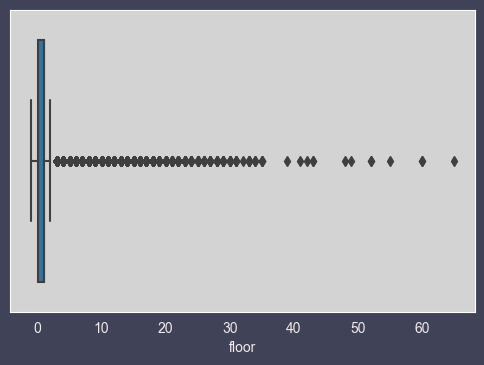

In [107]:
sns.boxplot(x=datos_10.floor)

(0.0, 40000.0)

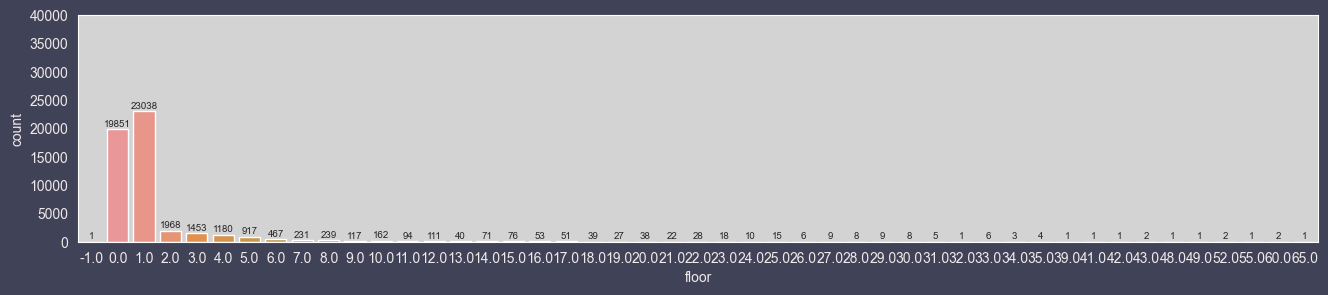

In [108]:
fig, ax = plt.subplots(figsize=(16,3))
sns.countplot(x=datos_10.floor, ax=ax)
patches = [p.get_height() for p in ax.patches]
x_coord = [patch.get_x() for patch in ax.patches]
for k in range(len(patches)):
    ax.annotate(round(patches[k],0), xy=(x_coord[k]+0.4,patches[k]+500),horizontalalignment='center', fontsize=7)
plt.ylim(0,40000)

En este caso, por la cantidad de departamentos que hay en los pisos más altos, no parece ser necesario eliminar ninguna fila, dado que los valores que vemos parecen provenir de la variación natural de esta variable. Solo cambiaremos el -1 por un 1, dado que sospechamos hubo un error de captura.

In [109]:
datos_11 = datos_10.copy()
datos_11.loc[:,'floor'] = datos_11.floor.replace(-1, 1)

(0.0, 40000.0)

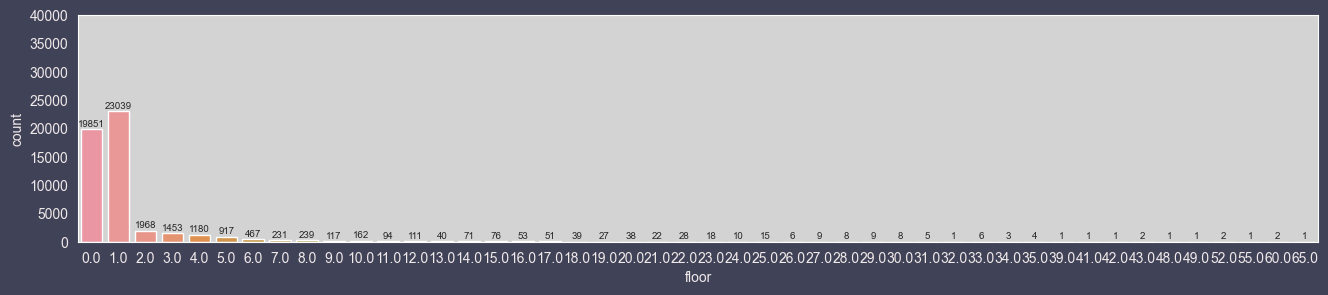

In [110]:
fig, ax = plt.subplots(figsize=(16,3))
sns.countplot(x=datos_11.floor, ax=ax)
patches = [p.get_height() for p in ax.patches]
x_coord = [patch.get_x() for patch in ax.patches]
for k in range(len(patches)):
    ax.annotate(round(patches[k],0), xy=(x_coord[k]+0.4,patches[k]+500),horizontalalignment='center', fontsize=7)
plt.ylim(0,40000)

### 3.6 Building Size

In [111]:
datos_11.building_size.describe()

count     86002.000000
mean        203.843375
std        4723.455433
min           0.000000
25%          70.000000
50%         110.000000
75%         210.000000
max      981700.000000
Name: building_size, dtype: float64

<AxesSubplot:xlabel='building_size'>

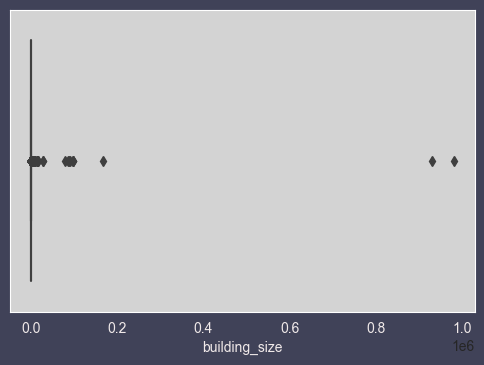

In [112]:
sns.boxplot(x=datos_11.building_size)

Vemos que hay claros datos atípicos, por sentido común, no esperamos que haya inmuebles habitacionales con más de 10,000 metros cuadrados de construcción.

In [113]:
datos_11 = datos_11[datos_11.building_size<10000]

<AxesSubplot:xlabel='building_size'>

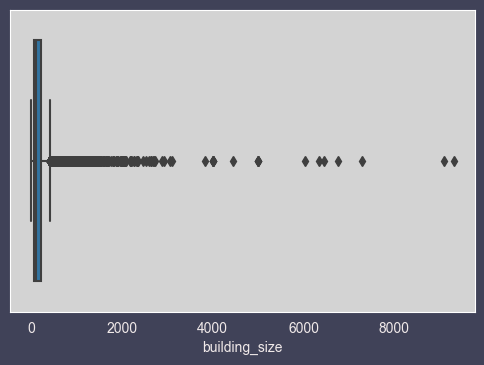

In [114]:
sns.boxplot(x=datos_11.building_size)

En este caso, parece difícil diferenciar cuáles son valores válidos y cuáles son errores en la información. Usaremos nuestro criterio de 3 desviaciones estándar arriba de la media para sabes cuáles son datos atípicos.

In [115]:
max_lim = datos_11.building_size.mean()+3*datos_11.building_size.std()

In [116]:
datos_11 = datos_11[datos_11.building_size <= max_lim]

<AxesSubplot:xlabel='building_size', ylabel='Count'>

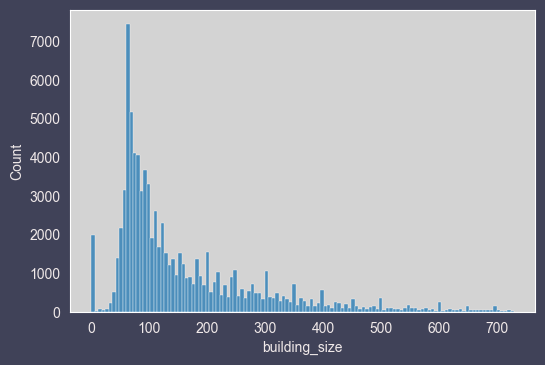

In [117]:
sns.histplot(x=datos_11.building_size)

Asimismo, sabiendo que se trata de casas o departamentos y no de terrenos, podemos concluir que es imposible que la construcción sea de 0 metros cuadrados. Por tanto, reemplazaremos los 0 por valores nulos.

In [118]:
datos_11.loc[:,'building_size'] = datos_11.building_size.replace(0, np.nan)

<AxesSubplot:xlabel='building_size', ylabel='Count'>

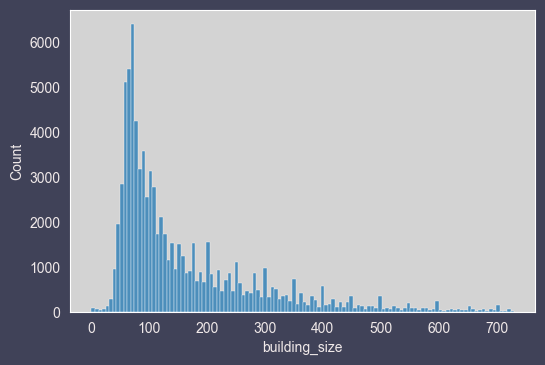

In [119]:
sns.histplot(x=datos_11.building_size)

Asimismo, debemos considerar el mínimo. Suena poco creíble que haya un inmueble con 1 metro cuadrado de construcción. Por tanto, definiremos un mínimo de 25 metros cuadrados para esta variable, que es un microdepartamento. 

In [120]:
datos_11 = datos_11[datos_11.building_size>25]

### 3.7 Price

Esta variable es de alta importancia dado que será la variable de respuesta en los modelos que crearemos posteriormente. 

In [121]:
datos_12 = datos_11.copy()
datos_12.price.describe()

count    8.255000e+04
mean     8.574915e+06
std      1.908146e+08
min      1.000000e+00
25%      8.800000e+05
50%      3.030546e+06
75%      6.263550e+06
max      2.719233e+10
Name: price, dtype: float64

Vemos que el máximo precio es de 27000 millones de pesos, lo cual claramente es un error en la información. 

In [122]:
datos_12.price.min()

1.0

Asimismo, el precio mínimo es de 1 peso, lo cual también es un error claramente.

Basándonos en artículos encontrados en internet, concluimos que la casa más cara en el país se vendió por 450 millones de pesos. Entonces, cualquier valor arriba de ese límite será considerado un error y eliminado.

In [123]:
datos_12 = datos_12[datos_12.price<450000000]

<AxesSubplot:xlabel='price'>

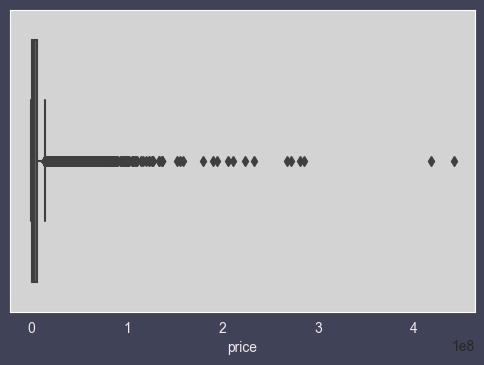

In [124]:
sns.boxplot(x=datos_12.price)

Vemos que hay una propiedad que se vende por poco más de 400 millones de pesos. Sin embargo, está bastante lejos de los demás valores, por lo cual la consideraremos también un error y la eliminaremos.

In [125]:
datos_12 = datos_12[datos_12.price<250000000]

Ahora, debemos considerar que estamos tratando con dos distintos tipos de operaciones: renta y venta. Por eso, en esta parte separaremos nuestro conjunto de datos en dos.

In [126]:
venta = datos_12[datos_12.operacion == 'venta']
renta = datos_12[datos_12.operacion == 'renta']

#### 3.7.1 Inmuebles en renta

In [127]:
renta.price.describe()

count    1.103100e+04
mean     7.949663e+04
std      1.324414e+06
min      1.000000e+00
25%      1.900000e+04
50%      2.750000e+04
75%      4.500000e+04
max      1.063475e+08
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

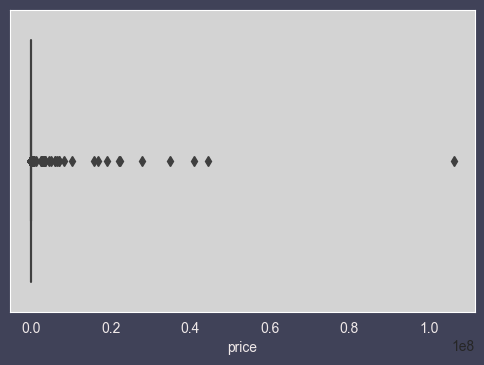

In [128]:
sns.boxplot(x=renta.price)

Encontramos que hay un inmueble con una renta de más de 100 millones de pesos, lo cual no tiene sentido. Consideraremos ese como un error de información. Asimismo, vemos algunos inmuebles con rentas de 20 millones de pesos, lo cual, de nuevo, no es realista. Como primer corte, quitaremos todos los registros con renta de más de un millón de pesos, lo cual sigue siendo extremadamente alto.

In [129]:
renta = renta[renta.price<1000000]

<AxesSubplot:xlabel='price'>

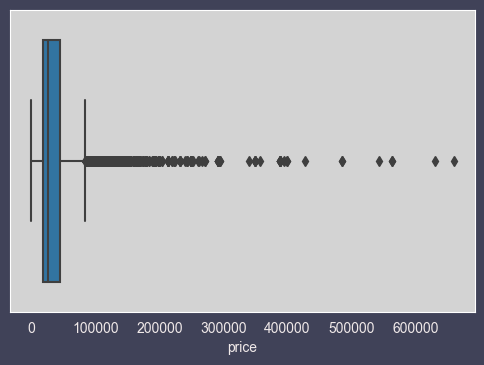

In [130]:
sns.boxplot(x=renta.price)

Seguimos viendo que hay inmuebles con rentas mayores a los 100 mil pesos mensuales. Recurriremos al criterio de tres desviaciones estándar para definir cuáles valores se quedarán.

In [131]:
lim_max = renta.price.mean()+3*renta.price.std()
lim_max

155474.75448259705

In [132]:
renta = renta[renta.price<lim_max]

Asimismo, es imposible que se rente un inmueble por 1 peso, por lo cual estableceremos un mínimo, tal vez arbitrario, de 3 mil pesos de renta. Cambiaremos todas las rentas menores a esa por 3 mil.

In [133]:
renta['price'] = renta.price.apply(lambda x: 3000 if x<3000 else x)

<AxesSubplot:xlabel='price', ylabel='Count'>

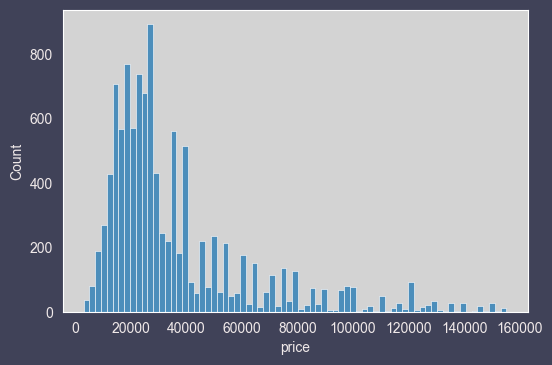

In [134]:
sns.histplot(x=renta.price)

In [135]:
renta.price.describe()

count     10825.000000
mean      36190.526596
std       26996.099052
min        3000.000000
25%       18900.000000
50%       27000.000000
75%       42000.000000
max      155200.000000
Name: price, dtype: float64

#### 3.7.2 Inmuebles en venta

In [136]:
venta.price.describe()

count    7.147200e+04
mean     6.305731e+06
std      8.910843e+06
min      1.000000e+00
25%      1.500000e+06
50%      3.654222e+06
75%      7.000000e+06
max      2.328000e+08
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

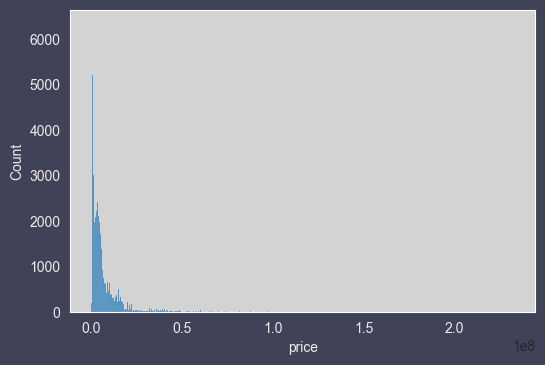

In [137]:
sns.histplot(x=venta.price)

Si bien previamente quitamos los inmuebles en venta por más de 450 millones, vemos que aún hay valores atípicos que parecen ser errores. Por esto, usaremos nuevamente la desviación estándar para limitar los datos.

In [138]:
max_lim = venta.price.mean()+3*venta.price.std()
max_lim

33038259.970728926

Sin embargo, sabemos que no es imposible que un inmueble en la ciudad de México cueste más de 33 millones de pesos. Por tanto, estableceremos un límite un poco mayor, y usaremos 5 desviaciones estándar.

In [139]:
max_lim = venta.price.mean()+5*venta.price.std()
max_lim

50859945.74215334

In [140]:
venta = venta[venta.price<max_lim]

<AxesSubplot:xlabel='price', ylabel='Count'>

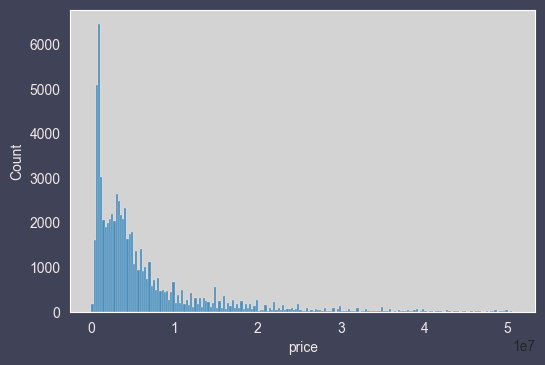

In [141]:
sns.histplot(x=venta.price)

Ahora, debemos considerar que hay inmuebles anunciados en la página web que están en remate bancario y por lo tanto no reflejan el precio de mercado del inmueble. La solución que daremos a este problema es algo arbitraria pero consideramos que es una medida no demasiado dañina a la calidad de la información. Basándonos en la visualización manual de la página web, notamos que casi la totalidad de los inmuebles ofercidos en menos de 1.3 millones de pesos estaban en condición de recuperación bancaria. Por tanto, usaremos ese como límite inferior para el precio.

In [142]:
min_lim = 1300000

In [143]:
venta = venta[venta.price>min_lim]

In [144]:
venta.shape

(54747, 15)

<AxesSubplot:xlabel='price', ylabel='Count'>

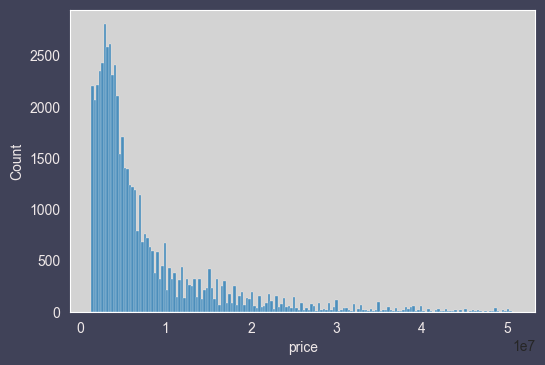

In [145]:
sns.histplot(x=venta.price)

In [146]:
datos_13 = pd.concat([venta,renta], ignore_index=True)

In [147]:
datos_13.shape

(65572, 15)

### 3.8 Land Size

En este caso, solo las casas tienen valores para esta variable. Por tanto, extraeremos solo las casas.

In [148]:
casas = datos_13[datos_13.category=='casa']
departamentos = datos_13[datos_13.category=='departamento']

In [149]:
casas.shape

(12724, 15)

In [150]:
casas.land_size.describe()

count    1.272000e+04
mean     1.459931e+03
std      8.864416e+04
min      0.000000e+00
25%      1.500000e+02
50%      2.160000e+02
75%      3.580000e+02
max      9.150000e+06
Name: land_size, dtype: float64

<AxesSubplot:xlabel='land_size'>

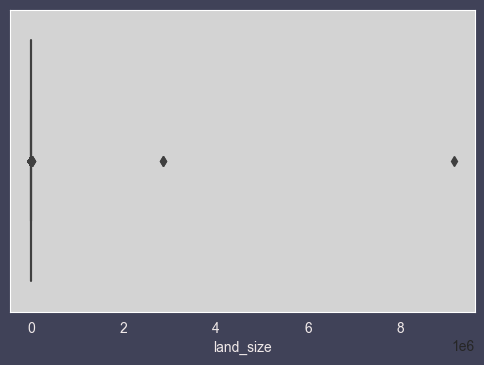

In [151]:
sns.boxplot(x=casas.land_size)

Vemos que hay un par claro de valores atípicos. Los quitaremos del conjunto de datos. Limitaremos las posibles extensiones de terreno a una hectárea, lo cual suena enorme, pero aún razonable.

In [152]:
casas = casas[casas.land_size<10000]

<AxesSubplot:xlabel='land_size'>

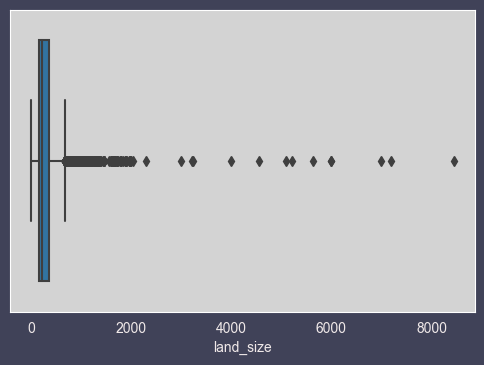

In [153]:
sns.boxplot(x=casas.land_size)

Nuevamente, usaremos el criterio de las tres desviaciones estándar.

In [154]:
lim_max = casas.land_size.mean()+3*casas.land_size.std()
lim_max

1142.1737587213465

In [155]:
casas = casas[casas.land_size<=lim_max]

También, considerando que las casas necesitan tener terreno por definición, sabemos que no hay casas que tengan 0 metros cuadrados de terreno. Por tanto, definiremos un mínimo de 36 metros cuadrados.

In [156]:
len(casas[casas.land_size<36])

705

Debido a que son bastantes las casas con terrenos reportados menores a 36 metros cuadrados, pondremos todas esas como valores nulos.

In [157]:
casas['land_size'] = casas.land_size.apply(lambda x: np.nan if x<36 else x)

<AxesSubplot:xlabel='land_size', ylabel='Count'>

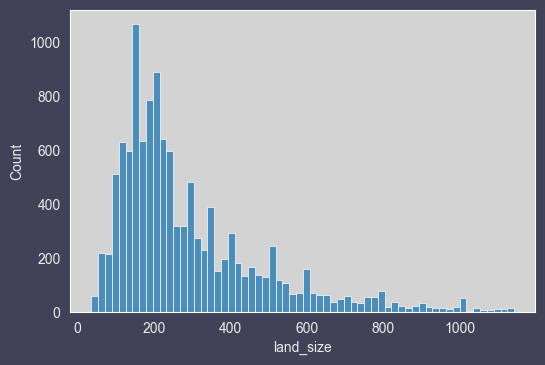

In [158]:
sns.histplot(casas.land_size)

In [159]:
datos_14 = pd.concat([casas,departamentos], ignore_index=True)

In [160]:
datos_14.head(2)

,category,bedrooms,car_spaces,bathrooms,floor,building_size,price,delegacion,land_size,sku,rango_precio,operacion,longitud,latitud,divisa
0,casa,3,3,3.0,NaN,217.0,1520000.0,alvaro-obregon,196.0,HO612928951E305MX,price:1000000-2000000,venta,-99.22132,19.33760,MXN
1,casa,3,3,2.0,NaN,200.0,1354000.0,alvaro-obregon,140.0,HO631BF09966781MX,price:1000000-2000000,venta,-99.19710,19.35339,MXN


### 3.9 Longitud

Los límites de la CDMX son:

Al Norte, 19° 35'

Al Sur, 19° 5'

Al Este, -98° 58'

Al Oeste, -99° 20'

In [161]:
datos_14.shape

(65423, 15)

In [162]:
limite_oeste = -99-(20/60)
limite_este = -98-(58/60)

In [163]:
fuera_longitud = datos_14[(datos_14.longitud<limite_oeste)|(datos_14.longitud>limite_este)]

In [164]:
len(fuera_longitud)

124

In [165]:
fuera_longitud.longitud.unique()

array([  99.22215   ,  -98.2062727 ,   19.13592   ,  -98.81968   ,
         99.14474   ,   99.12688   ,   99.1185    ,   99.15635   ,
         99.1192182 ,   99.13256   ,   99.165234  ,  -99.3369    ,
        -57.811205  ,   99.15122   ,  -58.3815591 ,  -98.81200049,
       -110.9711082 ,   99.16607293,   -9.03258839,  -99.973056  ,
         99.24221   ,   98.99894503,  -98.8017    , -103.4150146 ,
        -89.2469459 ,  -89.52013047,  -89.52013047,  -99.5377167 ,
        -97.9674599 ,  -97.0702615 ,  -98.2216931 , -118.2436849 ,
       -100.3329494 , -110.956789  ,   99.23995554, -116.5983444 ,
         99.175002  , -100.895788  ,   79.        ,   99.15495   ,
         99.15493   ,   99.18233   ,  -90.22492   , -104.88831854,
       -109.96108914,  -80.1917902 , -102.552784  ,  -86.158068  ,
        -97.7919864 , -100.37367   ,   99.15326   ,   99.17188   ,
         99.12178722, -103.3732822 , -103.3672802 ,  -99.6556784 ,
        -58.4302476 ,  -99.738918  ,  -96.1652929 , -116.58949

Vemos que hay 124 inmuebles con coordenada de longitud que queda fuera de los límites de la ciudad. Como hay algunos que tienen las coordenadas positivas en vez de negativas, transformaremos todo a coordenadas negativas.

In [166]:
datos_14['longitud'] = datos_14.longitud.apply(lambda x : -x if x>0 else x)

In [167]:
fuera_longitud = datos_14[(datos_14.longitud<limite_oeste)|(datos_14.longitud>limite_este)]

In [168]:
len(fuera_longitud)

95

In [169]:
fuera_longitud.longitud.unique()

array([ -98.2062727 ,  -19.13592   ,  -98.81968   ,  -99.3369    ,
        -57.811205  ,  -58.3815591 ,  -98.81200049, -110.9711082 ,
         -9.03258839,  -99.973056  ,  -98.8017    , -103.4150146 ,
        -89.2469459 ,  -89.52013047,  -89.52013047,  -99.5377167 ,
        -97.9674599 ,  -97.0702615 ,  -98.2216931 , -118.2436849 ,
       -100.3329494 , -110.956789  , -116.5983444 , -100.895788  ,
        -79.        ,  -90.22492   , -104.88831854, -109.96108914,
        -80.1917902 , -102.552784  ,  -86.158068  ,  -97.7919864 ,
       -100.37367   , -103.3732822 , -103.3672802 ,  -99.6556784 ,
        -58.4302476 ,  -99.738918  ,  -96.1652929 , -116.5894941 ,
       -105.4595306 ,  -19.454351  , -103.3851024 ,  -99.89615   ,
       -103.6043    ,  -98.18686   , -106.8654066 ,   -3.7037902 ,
        -19.48504   ,   -4.0273231 , -122.4194155 , -103.0126523 ,
        -86.8803641 , -100.1334335 ,  -59.5314088 ,  -98.9501634 ,
        -99.3613955 ,  -96.482203  ,  -86.8299566 ,  -97.80234

In [170]:
datos_15 = datos_14[(datos_14.longitud>=limite_oeste)&(datos_14.longitud<=limite_este)]

In [171]:
len(datos_15)

65328

### 3.9 Latitud

In [172]:
limite_norte = 19+(35/60)
limite_sur = 19+(5/60)

In [173]:
fuera_latitud = datos_15[(datos_15.latitud<limite_sur)|(datos_15.latitud>limite_norte)]

In [174]:
len(fuera_latitud)

28

In [175]:
fuera_latitud.latitud.unique()

array([ 1.        , 18.819491  , 18.9621832 , 19.733219  , 19.63987   ,
       19.7018    , 19.        , 19.6496407 , 19.64718   , 18.9310297 ,
       18.9477777 , 19.6716    , 20.27978705, 19.6162033 , 19.5902363 ,
        1.402256  ])

In [176]:
datos_16 = datos_15[(datos_15.latitud>=limite_sur)&(datos_15.latitud<=limite_norte)]

In [177]:
datos_16.shape

(65300, 15)

## 4. Duplicados

Ahora, revisaremos si hay filas duplicadas y las quitaremos si es el caso. Nos basaremos en la columna SKU, dado que, por la manera en que obtuvimos los datos, un solo departamento puede salir dos veces, estando en dos categorías de precio. Por ejemplo, si cuesta 1 millón, saldrá en la categoría 0-1 millón y también la de 1-2 millones.

In [178]:
datos_17 = datos_16.drop_duplicates(subset='sku')

In [179]:
datos_17.shape

(63291, 15)

## 5. Valores faltantes

In [180]:
datos_17.isna().sum()

category             0
bedrooms             0
car_spaces           0
bathrooms            0
floor            20295
building_size        0
price                0
delegacion           0
land_size        51740
sku                  0
rango_precio         0
operacion            0
longitud             0
latitud              0
divisa               0
dtype: int64

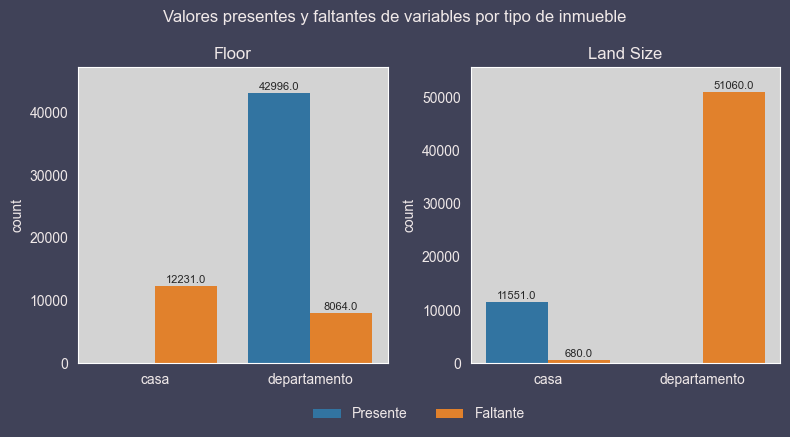

In [187]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
variables = ['floor', 'land_size']
nombres = ['Floor', 'Land Size']
coordinates = [-.2,0.2,0.8,1.2]

for i in range(2):
    sns.countplot(hue=datos_17[variables[i]].isna(), x=datos_17.category, ax=ax[i], linewidth = 0)
    ax[i].set_title(nombres[i])
    ax[i].get_legend().remove()
    ax[i].set_ylim(top=ax[i].get_ylim()[1]+2000)
    ax[i].set_xlabel('')
    order = [0,2,1,3]
    patches = [p.get_height() for p in ax[i].patches]
    heights = [patches[j] for j in order]
    for k in range(4):
        ax[i].annotate(round(heights[k],0), xy=(coordinates[k],heights[k]+500),horizontalalignment='center', fontsize=8)


fig.legend(['Presente', 'Faltante'], loc='lower center',bbox_to_anchor=(0.53,-0.08), ncol=2, )
plt.suptitle('Valores presentes y faltantes de variables por tipo de inmueble', color='#F0E9E9')
plt.tight_layout()
plt.show()

Vemos, entonces, que debemos imputar los 680 valores de land size para las casas y los 8064 para los departamentos que no cuentan con floor.

### 5.1 Land Size

Debido a que son pocos los valores faltantes en esta variable, llenaremos con la mediana.

In [184]:
datos_18 = datos_17.copy()
value = datos_18.land_size.median()

def fill_land_size(row):
    if row.category == 'departamento':
        return row.land_size
    elif np.isnan(row.land_size):
        return value
    return row.land_size

datos_18['land_size'] = datos_18.apply(fill_land_size, axis=1)

### 5.2 Floor

En esta parte, nuevamente separaremos nuestos datos en dos dataframes: departamentos y casas.

In [189]:
casas = datos_18[datos_18.category=='casa']
departamentos = datos_18[datos_18.category=='departamento']

In [190]:
departamentos.head()

,category,bedrooms,car_spaces,bathrooms,floor,building_size,price,delegacion,land_size,sku,rango_precio,operacion,longitud,latitud,divisa
12575,departamento,2,1,1.0,NaN,76.0,1530000.0,alvaro-obregon,NaN,AP63801578731D0MX,price:1000000-2000000,venta,-99.193000,19.380630,MXN
12576,departamento,2,1,1.0,2.0,54.0,1680000.0,alvaro-obregon,NaN,AP630912D45A699MX,price:1000000-2000000,venta,-99.212440,19.369820,MXN
12577,departamento,2,2,1.0,4.0,64.0,1490000.0,alvaro-obregon,NaN,AP62E9BD041AFA2MX,price:1000000-2000000,venta,-99.203821,19.367506,MXN
12578,departamento,3,2,1.0,0.0,62.0,1650000.0,alvaro-obregon,NaN,AP6320084A4DE46MX,price:1000000-2000000,venta,-99.246537,19.364338,MXN
12579,departamento,3,1,1.0,2.0,70.0,1950000.0,alvaro-obregon,NaN,AP61AEAD7DB724DMX,price:1000000-2000000,venta,-99.253980,19.355750,MXN


La estrategia será imputar los valores respetando la distribución que tenemos hasta ahora. Es decir, seleccionar aleatoriamente los valores tomando en cuenta la proporción que representa cada uno de los valores.

<AxesSubplot:xlabel='floor', ylabel='count'>

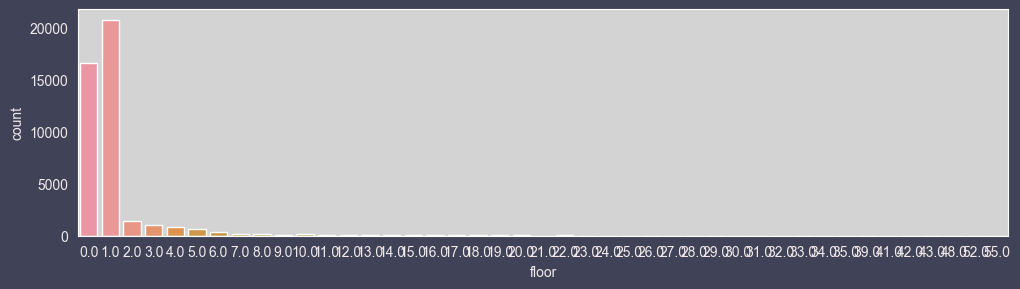

In [191]:
fig, ax = plt.subplots(figsize=(12,3))
sns.countplot(x=departamentos.floor)

In [192]:
proportions = departamentos.floor.value_counts().sort_index().values
values = departamentos.floor.value_counts().sort_index().index
sample = pd.Series(random.choices(values, proportions, k=8064))
sample.index = departamentos[departamentos.floor.isna()].index

<AxesSubplot:ylabel='count'>

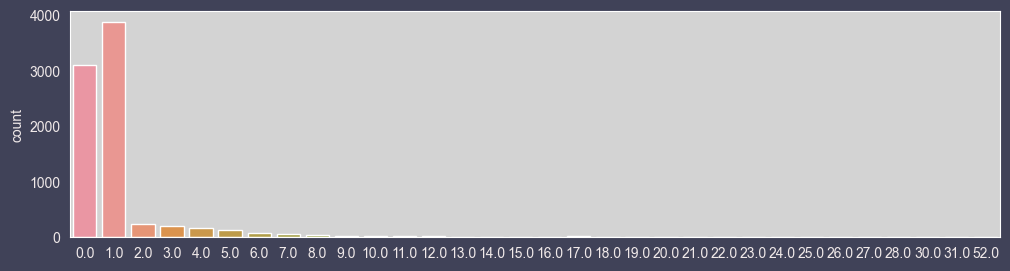

In [193]:
fig, ax = plt.subplots(figsize=(12,3))
sns.countplot(x=sample)

In [194]:
depa2 = departamentos.copy()
depa2.floor.fillna(sample, inplace=True)

<AxesSubplot:xlabel='floor', ylabel='count'>

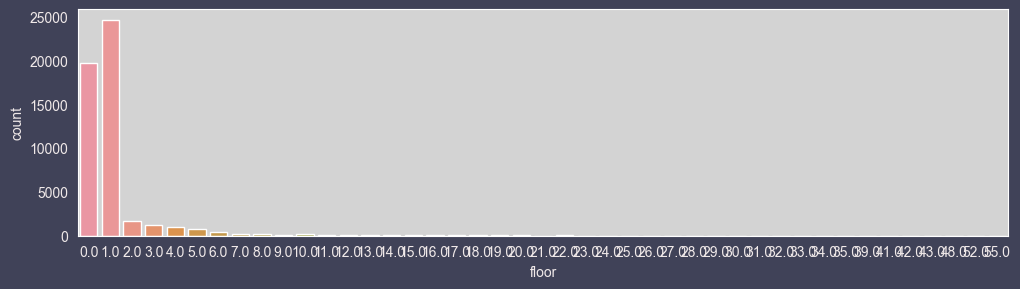

In [195]:
fig, ax = plt.subplots(figsize=(12,3))
sns.countplot(x=depa2.floor)

In [196]:
datos = pd.concat([casas, depa2], ignore_index=True)

In [197]:
datos.isna().sum()

category             0
bedrooms             0
car_spaces           0
bathrooms            0
floor            12231
building_size        0
price                0
delegacion           0
land_size        51060
sku                  0
rango_precio         0
operacion            0
longitud             0
latitud              0
divisa               0
dtype: int64

Con esto, consideramos que tenemos los datos limpios y podemos comenzar a trabajar con ellos.

In [198]:
datos.to_csv('inmuebles.csv')

### 6. Exploración y Feature Engineering

In [2]:
datos = pd.read_csv('inmuebles.csv', index_col = 0)
delegaciones_formato = ['Álvaro Obregón','Azcapotzalco','Benito Juárez','Coyoacán','Cuajimalpa','Cuauhtémoc',
                'Gustavo A. Madero','Iztacalco','Iztapalapa','Magdalena Contreras','Miguel Hidalgo', 'Milpa Alta',
                'Tláhuac','Tlalpan','Venustiano Carranza','Xochimilco']
delegaciones = datos.delegacion.unique()
sustitutos_dict = {delegaciones[i]:delegaciones_formato[i] for i in range(16)}
datos.replace(sustitutos_dict, inplace=True)

In [3]:
venta = datos[datos.operacion == 'venta']
renta = datos[datos.operacion == 'renta']
departamentos = datos[datos.category == 'departamento']
casas = datos[datos.category == 'casa']

In [5]:
datos.head(2)

,category,bedrooms,car_spaces,bathrooms,floor,building_size,price,delegacion,land_size,sku,rango_precio,operacion,longitud,latitud,divisa
0,casa,3,3,3.0,NaN,217.0,1520000.0,Álvaro Obregón,196.0,HO612928951E305MX,price:1000000-2000000,venta,-99.22132,19.33760,MXN
1,casa,3,3,2.0,NaN,200.0,1354000.0,Álvaro Obregón,140.0,HO631BF09966781MX,price:1000000-2000000,venta,-99.19710,19.35339,MXN


En este proyecto lo que nos interesa es encontrar propiedades en las que sea conveniente invertir. Es decir, queremos encontrar propiedades que se puedan comprar a un precio menor a su valor, con el objetivo de revenderlas o rentarlas.

Primero, veremos cuáles son los precios medios de un inmueble en las delegaciones de la Ciudad de México.

In [8]:
sns.set_style('whitegrid')
sns.set_style(rc={'axes.facecolor':'#eeeeee', 'figure.facecolor':'2A3142'})
plt.rcParams["legend.labelcolor"] = '#F0E9E9'
plt.rcParams['axes.labelcolor']='#F0E9E9'
plt.rcParams['xtick.labelcolor']='#F0E9E9'
plt.rcParams['ytick.labelcolor']='#F0E9E9'
plt.rcParams['axes.titlecolor']='#F0E9E9'
plt.rcParams['legend.facecolor']='#2A3142'
plt.rcParams['legend.edgecolor']= '#2A3142'
plt.rcParams['figure.dpi']='100'

In [54]:
def millions(x, pos):
    return '%1.1f' % (x * 1e-6)

formatter = ticker.FuncFormatter(millions)

In [6]:
def thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

formatter2 = ticker.FuncFormatter(thousands)

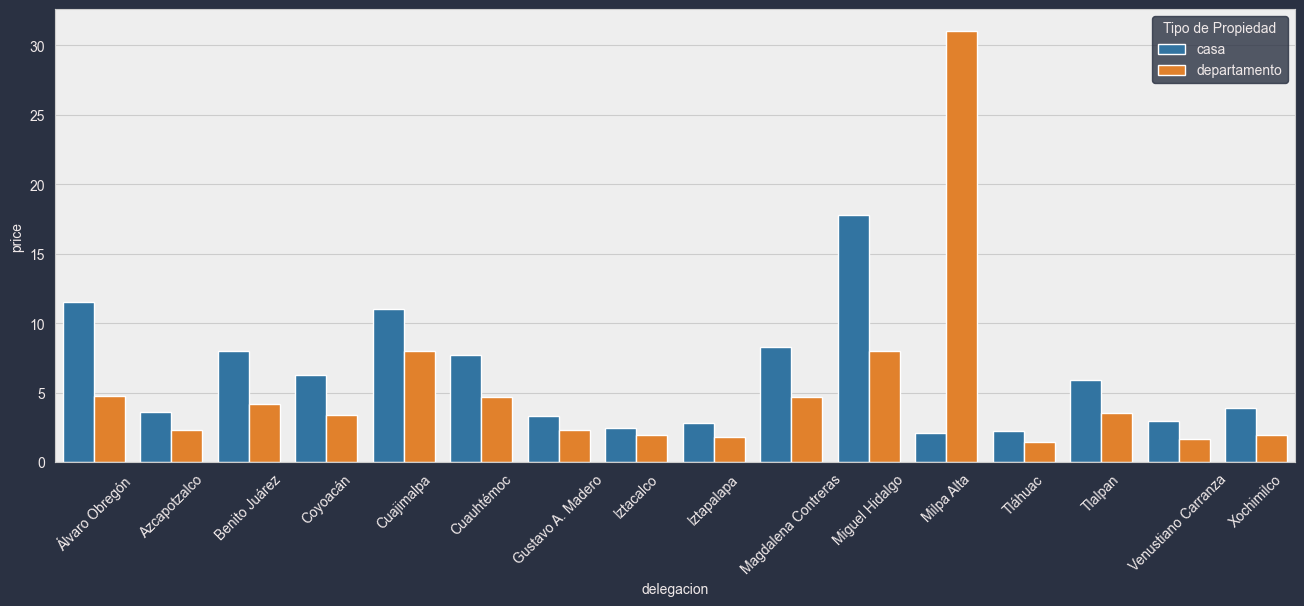

In [9]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(data=venta, x='delegacion', y='price', hue='category', estimator=np.median,ci=None, ax=ax)
legend = plt.legend(title="Tipo de Propiedad", labelcolor='#F0E9E9')
plt.setp(legend.get_title(), color='#F0E9E9')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(formatter)
plt.show()

Encontramos que los departamentos en Milpa Alta cuestan, en promedio, más de 30 millones de pesos. Por conocimiento sobre la Ciudad de México, y comparando con el precio de las casas en esa misma delegación, sabemos que debe haber algún error en los datos. Los revisaremos.

In [14]:
datos[datos.delegacion =='Milpa Alta']

,category,bedrooms,car_spaces,bathrooms,floor,building_size,price,delegacion,land_size,sku,rango_precio,operacion,longitud,latitud,divisa
8949,casa,4,2,4.0,NaN,190.0,1400000.0,Milpa Alta,270.0,HO619C28D7E79C5MX,price:1000000-2000000,venta,-99.090180,19.192380,MXN
8950,casa,3,0,1.0,NaN,218.0,1500000.0,Milpa Alta,210.0,HO6299BA3EF1C7AMX,price:1000000-2000000,venta,-98.986075,19.211008,MXN
8951,casa,3,3,3.0,NaN,228.0,2750000.0,Milpa Alta,200.0,HO62DCC74C3E96DMX,price:2000000-3000000,venta,-99.068363,19.203568,MXN
8952,casa,2,1,1.0,NaN,274.0,5350000.0,Milpa Alta,1016.0,HO619F3E0606A5CMX,price:5000000-7000000,venta,-99.020350,19.193931,MXN
51990,departamento,2,0,2.0,0.0,213.0,13580000.0,Milpa Alta,NaN,AP5F527C4718A03MX,price:10000000-15000000,venta,-98.994420,19.217530,USD
51991,departamento,2,0,2.0,0.0,489.0,48500000.0,Milpa Alta,NaN,AP5F527C488BC6EMX,price:15000000+,venta,-98.994420,19.217530,USD


Vemos que solamente hay dos departamentos y cuatro casas en Milpa Alta. Ya sea en venta o en renta. Asimismo, los precios de los departamentos son erróneos. Eliminaremos Esta delegación del conjunto de datos.

In [10]:
datos = datos[(datos.delegacion!='Milpa Alta')]
datos = datos[(datos.delegacion!='Tláhuac')]
datos['precio_por_metro_construccion'] = datos.price/datos.building_size
venta = datos[datos.operacion == 'venta']
renta = datos[datos.operacion == 'renta']
departamentos = datos[datos.category == 'departamento']
casas = datos[datos.category == 'casa']


In [22]:
paleta_orden = [(1.0, 0.4980392156862745, 0.054901960784313725),(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

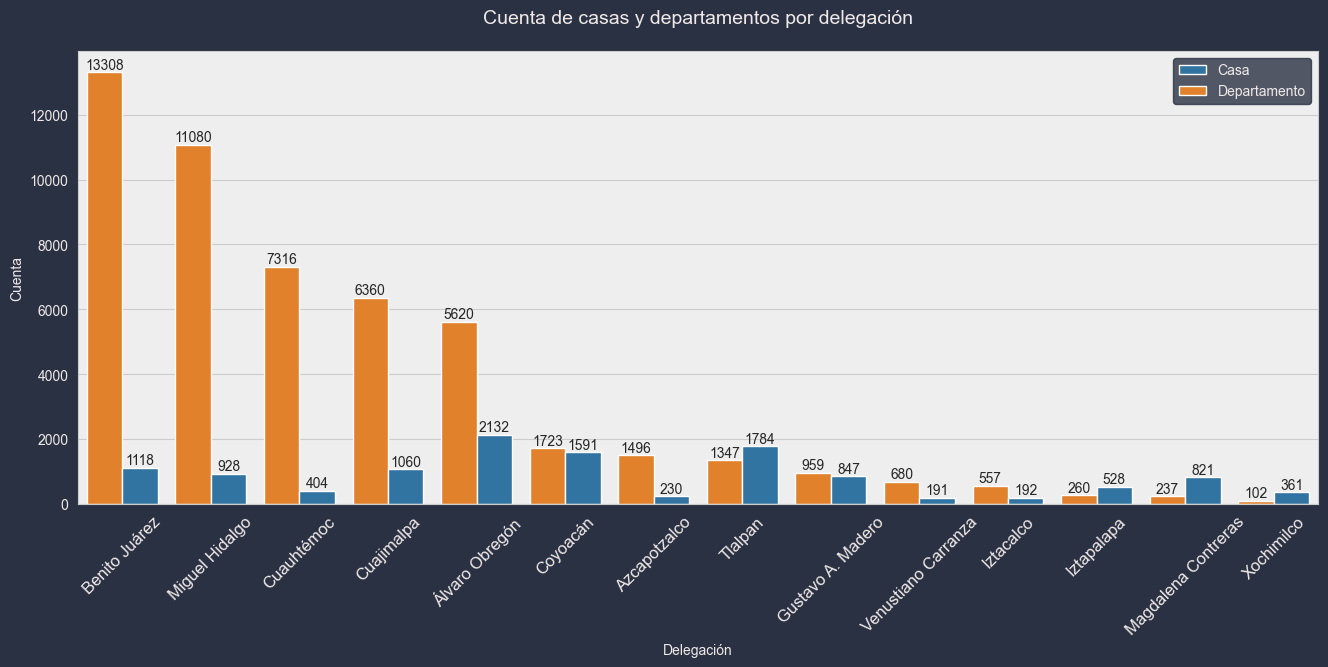

In [36]:
fig, ax = plt.subplots(figsize=(16,6))
sns.countplot(data=datos, x='delegacion', hue='category', ax=ax, 
              order=datos[datos.category=='departamento'].delegacion.value_counts().sort_values(ascending=False).index, hue_order=['departamento','casa'],
             palette = paleta_orden)
patches = [p.get_height() for p in ax.patches]
x_coord = [patch.get_x() for patch in ax.patches]
for k in range(len(patches)):
    ax.annotate(round(patches[k],0), xy=(x_coord[k]+0.2,patches[k]+100),horizontalalignment='center', fontsize=10)
ax.set_title('Cuenta de casas y departamentos por delegación', fontdict={'fontsize':14}, pad=20)
ax.set_xlabel('Delegación')
ax.set_ylabel('Cuenta')
legend = plt.legend([ax.patches[20],ax.patches[10]],['Casa', 'Departamento'],title=None, labelcolor='#F0E9E9')
plt.setp(legend.get_title(), color='#F0E9E9')
plt.xticks(rotation=45, fontsize=12)
plt.savefig(r'C:\Users\omarp\Documents\Proyectos\Portafolios\images2\cuenta_inmuebles_por_tipo.png', bbox_inches='tight')
plt.show()

In [17]:
len(datos)

63232

Vemos que en Tláhuac hay muy pocos inmuebles en oferta. Consideramos que esto dificultará el análisis, sobre todo cuando se segmente por alguna otra variable como rango de precio. Por tanto, se decide quitar las viviendas de esta delegación del conjunto de datos. Asimismo, creamos la variable Precio por metro de construcción.

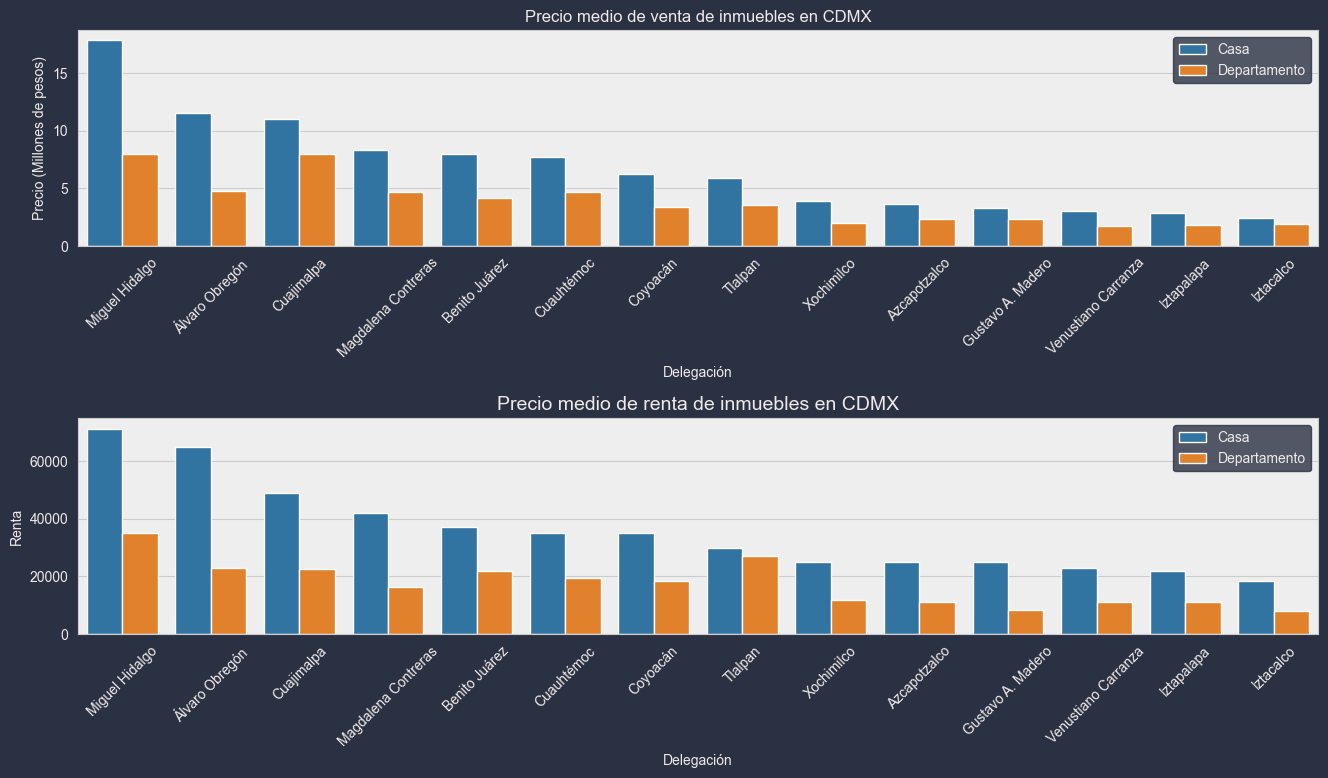

In [18]:
order = venta[venta.category=='casa'].groupby(['delegacion']).price.median().sort_values(ascending=False).index
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,8))
sns.barplot(data=venta, x='delegacion', y='price', hue='category', ci=None, ax=ax1,estimator=np.median, order=order)

ax1.yaxis.set_major_formatter(formatter)
ax1.set_xlabel('Delegación')
ax1.set_ylabel('Precio (Millones de pesos)')
ax1.set_title('Precio medio de venta de inmuebles en CDMX')
ax1.legend(['Casa', 'Departamento'],title=None, labelcolor='#F0E9E9')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

order = renta[renta.category=='casa'].groupby(['delegacion']).price.median().sort_values(ascending=False).index
sns.barplot(data=renta, x='delegacion', y='price', hue='category', ci=None, ax=ax2,estimator=np.median, order=order)
ax2.set_xlabel('Delegación')
ax2.set_ylabel('Renta')
ax2.set_title('Precio medio de renta de inmuebles en CDMX', fontdict={'fontsize':14})
ax2.legend(['Casa', 'Departamento'],title=None, labelcolor='#F0E9E9')
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=45)

plt.subplots_adjust(hspace=0.8)
plt.show()

In [19]:
promedio_venta_depas = venta[venta.category == 'departamento'].price.median()
promedio_venta_casas = venta[venta.category == 'casa'].price.median()

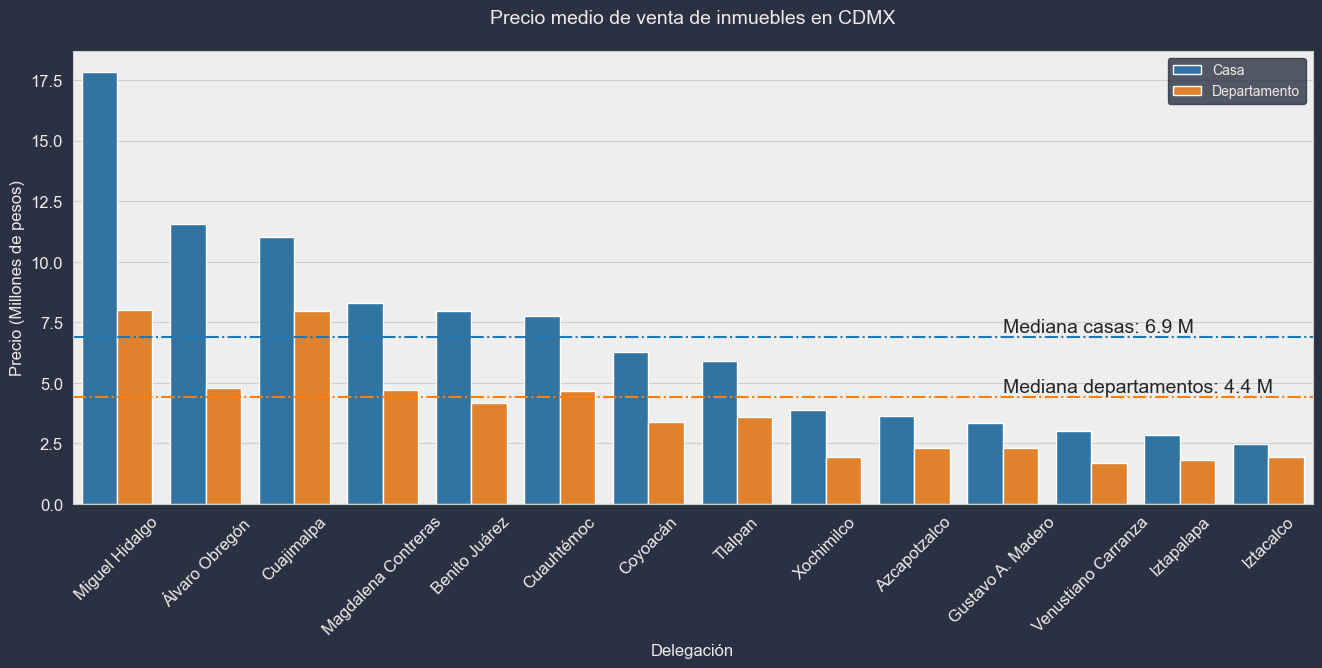

In [55]:
order = venta[venta.category=='casa'].groupby(['delegacion']).price.median().sort_values(ascending=False).index
fig, ax = plt.subplots(figsize=(16,6))


x_axis = np.linspace(-0.5, 13.5, 100)
ax.plot(x_axis,[promedio_venta_casas]*100, '-.')

ax.annotate('Mediana casas: {} M'.format(promedio_venta_casas/1000000), (10, promedio_venta_casas+200000), fontsize=14)


ax.plot(x_axis,[promedio_venta_depas]*100, '-.')

ax.annotate('Mediana departamentos: {:.1f} M'.format(promedio_venta_depas/1000000), (10, promedio_venta_depas+200000), fontsize=14)


sns.barplot(data=venta, x='delegacion', y='price', hue='category', ci=None, ax = ax, estimator=np.median, order=order)


ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Delegación', fontsize=12)
ax.set_ylabel('Precio (Millones de pesos)', fontsize=12)
ax.set_title('Precio medio de venta de inmuebles en CDMX', pad=20, fontdict={'fontsize':14})
ax.legend(['Casa', 'Departamento'],title=None, labelcolor='#F0E9E9')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
plt.yticks(fontsize=12)

ax.legend([ax.patches[0],ax.patches[20]],['Casa', 'Departamento'],title=None, labelcolor='#F0E9E9')

plt.savefig(r'C:\Users\omarp\Documents\Proyectos\Portafolios\images2\precio_medio_por_tipo.png', bbox_inches='tight')

plt.show()

In [50]:
venta.groupby(['category','delegacion']).price.median()

category      delegacion         
casa          Azcapotzalco            3615271.0
              Benito Juárez           7980000.0
              Coyoacán                6265000.0
              Cuajimalpa             11000000.0
              Cuauhtémoc              7739000.0
              Gustavo A. Madero       3320000.0
              Iztacalco               2455000.0
              Iztapalapa              2845500.0
              Magdalena Contreras     8280000.0
              Miguel Hidalgo         17813000.0
              Tlalpan                 5900000.0
              Venustiano Carranza     2987000.0
              Xochimilco              3890000.0
              Álvaro Obregón         11553750.0
departamento  Azcapotzalco            2288965.0
              Benito Juárez           4150000.0
              Coyoacán                3367800.0
              Cuajimalpa              7980000.0
              Cuauhtémoc              4674340.0
              Gustavo A. Madero       2320511.0
      

array([  0., 100., 200., 300., 400., 500., 600., 700., 800.])

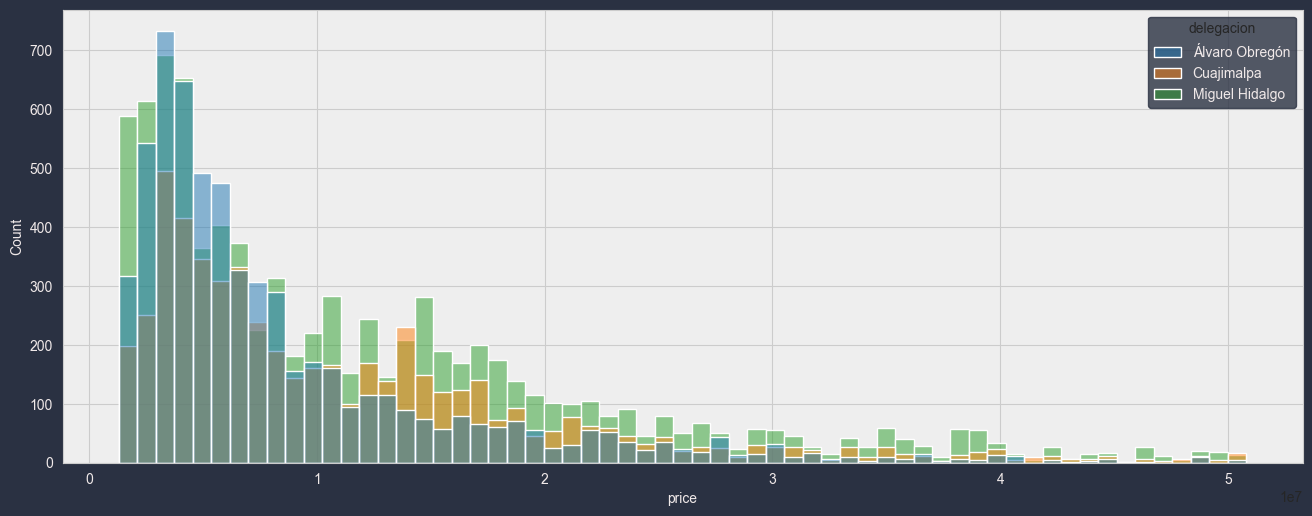

In [278]:
mas_caras = venta[(venta.delegacion == 'Miguel Hidalgo')|(venta.delegacion == 'Cuajimalpa')|(venta.delegacion == 'Álvaro Obregón')]

fig, ax = plt.subplots(figsize=(16,6))

sns.histplot(data=mas_caras, x='price', hue='delegacion')

ax.get_yticks()


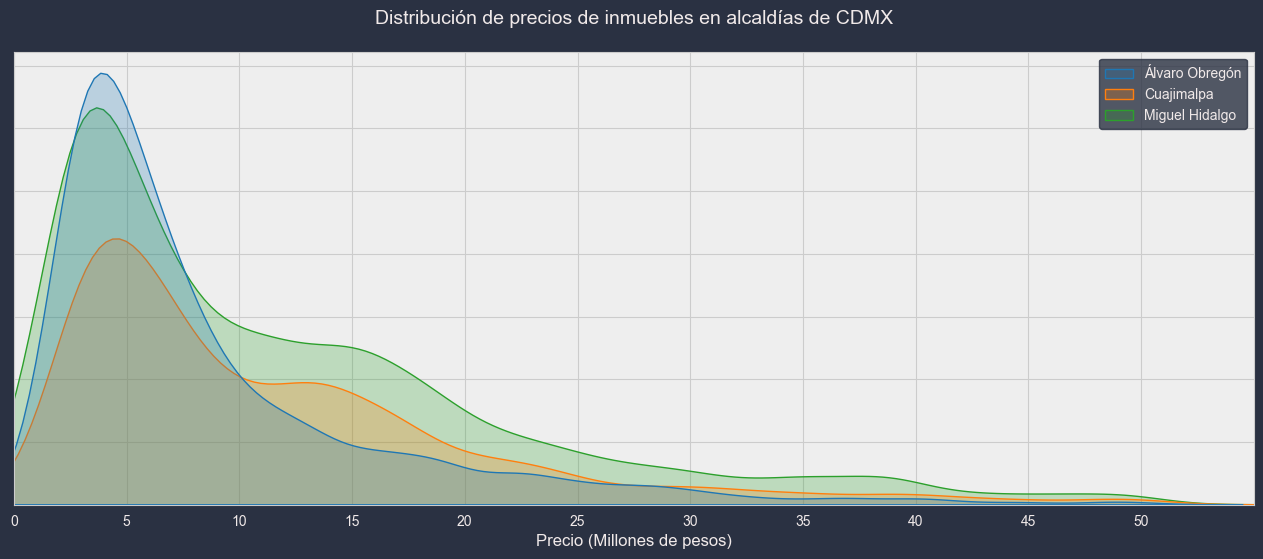

In [61]:
mas_caras = venta[(venta.delegacion == 'Miguel Hidalgo')|(venta.delegacion == 'Cuajimalpa')|(venta.delegacion == 'Álvaro Obregón')]

fig, ax = plt.subplots(figsize=(16,6))

sns.kdeplot(data=mas_caras, x='price', hue='delegacion', fill=True, common_norm=True)

ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('')
ax.legend_.set_title(None)
ax.set_title('Distribución de precios de inmuebles en alcaldías de CDMX', pad=20, fontsize=14)
ax.get_yaxis().set_ticklabels([])
ax.set_xlabel('Precio (Millones de pesos)', fontsize=12)
ax.set_xticks([5000000*i for i in range(11)])
ax.set_xlim((0, 55000000))
plt.savefig(r'C:\Users\omarp\Documents\Proyectos\Portafolios\images2\distribucion_mas_caras.png', bbox_inches='tight')
plt.show()




In [20]:
len(venta[venta.delegacion == 'Miguel Hidalgo'])

8452

In [22]:
len(venta[(venta.delegacion == 'Miguel Hidalgo')&(venta.price<=20000000)&(venta.price>=10000000)])

2439

In [23]:
2439/8452

0.288570752484619

In [98]:
venta.groupby(['delegacion', 'category']).std().price

delegacion           category    
Azcapotzalco         casa            2.770782e+06
                     departamento    1.806404e+06
Benito Juárez        casa            5.976662e+06
                     departamento    2.228901e+06
Coyoacán             casa            8.792150e+06
                     departamento    2.086530e+06
Cuajimalpa           casa            1.137378e+07
                     departamento    8.661105e+06
Cuauhtémoc           casa            8.144866e+06
                     departamento    3.953197e+06
Gustavo A. Madero    casa            3.402987e+06
                     departamento    1.240920e+06
Iztacalco            casa            2.564339e+06
                     departamento    8.721234e+05
Iztapalapa           casa            2.272415e+06
                     departamento    1.667264e+06
Magdalena Contreras  casa            5.784449e+06
                     departamento    2.993080e+06
Miguel Hidalgo       casa            1.334397e+07
                

In [93]:
venta[(venta.delegacion == 'Cuajimalpa')&(venta.category == 'departamento')].price.median()

7980000.0

In [54]:
def porcentaje_por_rango(minimo, maximo, datos):
    datos_filtrados = datos[(datos.price>minimo)&(datos.price<=maximo)]
    a = datos_filtrados.groupby('delegacion').count().category.sort_index().reset_index()
    b = datos.groupby('delegacion').count().category.sort_index().reset_index()
    merged = pd.merge(a,b,on='delegacion')
    rango = '{}_{}'.format(minimo/1000000, maximo/1000000)
    columna = 'porcentaje'+rango
    merged[columna] = merged.category_x/merged.category_y*100
    merged = merged[['delegacion', columna]]
    return merged
    

In [55]:
r1 = porcentaje_por_rango(0, 2500000, venta)
r2 = porcentaje_por_rango(2500000, 5000000, venta)
r3 = porcentaje_por_rango(5000000, 10000000, venta)
r4 = porcentaje_por_rango(10000000, 20000000, venta)
r5 = porcentaje_por_rango(20000000, 100000000, venta)

In [56]:
r1

,delegacion,porcentaje0.0_2.5
0,Azcapotzalco,60.446373
1,Benito Juárez,10.910888
2,Coyoacán,23.309258
3,Cuajimalpa,5.283505
4,Cuauhtémoc,16.884235
5,Gustavo A. Madero,46.447761
6,Iztacalco,71.014493
7,Iztapalapa,53.566622
8,Magdalena Contreras,9.933036
9,Miguel Hidalgo,10.127780


In [57]:
general = r1.merge(r2, how='left').merge(r3, how='left').merge(r4, how='left').merge(r5, how='left')
general.fillna(0, inplace=True)

In [58]:
cols = list(general.columns)[1:]
general['Total'] = sum(general[cols[i]] for i in range(5))
general.columns=['delegacion','a', 'b', 'c', 'd', 'e', 'Total']

In [59]:
acumulado = general.copy()
acumulado['b'] = acumulado.a+acumulado.b
acumulado['c'] = acumulado.b+acumulado.c
acumulado['d'] = acumulado.c+acumulado.d
acumulado['e'] = acumulado.d+acumulado.e

In [62]:
mas_caras[mas_caras.category=='departamento'].price.median()

6500000.0

In [63]:
mas_caras[mas_caras.category=='casa'].price.median()

12500000.0

In [64]:
mas_baratas = venta[(venta.delegacion == 'Iztacalco')|(venta.delegacion == 'Vensutiano Carranza')|(venta.delegacion == 'Iztapalapa')|(venta.delegacion == 'Azcapotzalco')]

In [65]:
mas_baratas[mas_baratas.category=='departamento'].price.median()

2185079.0

In [66]:
mas_baratas[mas_baratas.category=='casa'].price.median()

2857000.0

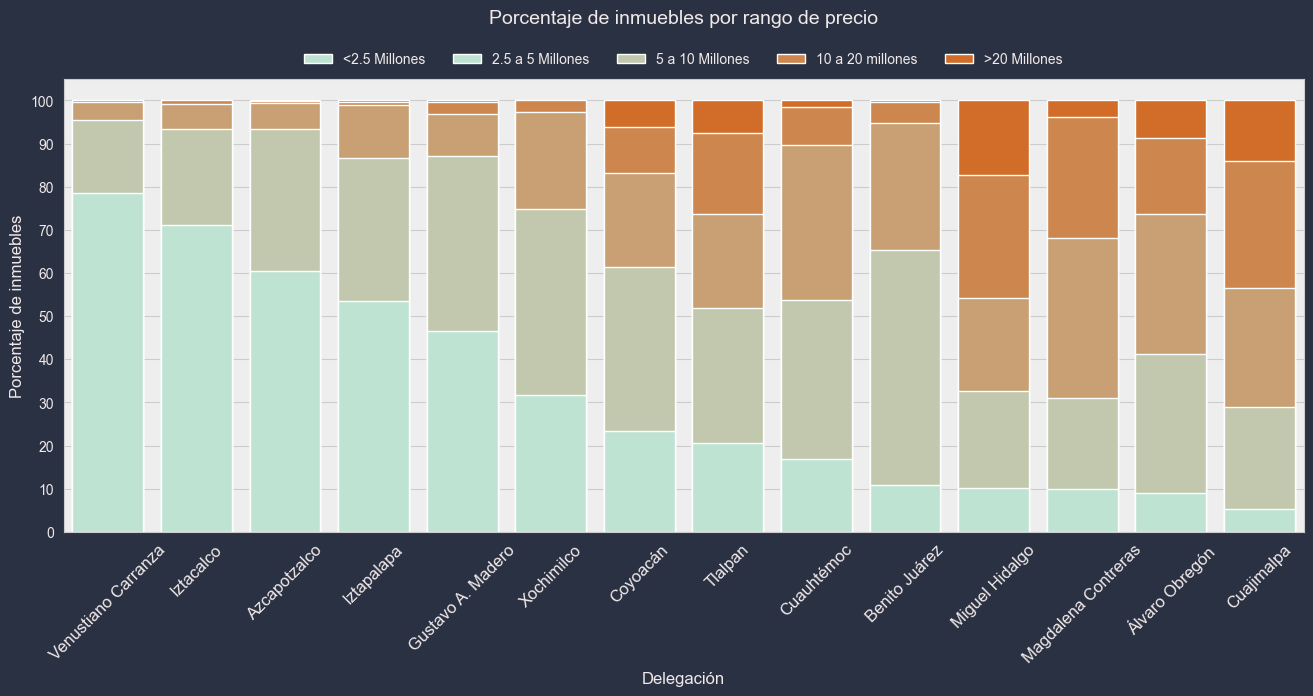

In [67]:
fig, ax = plt.subplots(figsize=(16,6))
colors = ['#EE670D','#E28439', '#D6A165', '#C4CCA8', '#B8E9D4']
var = ['e', 'd', 'c', 'b', 'a'] 
orden = acumulado.sort_values('a', ascending=False).delegacion
for i in range(len(var)):
    globals()['bar'+str(i)] = sns.barplot(data=acumulado[['delegacion', var[i]]], x='delegacion', y=var[i], color=colors[i], order=orden)
ax.set_ylabel('Porcentaje de inmuebles',fontsize=12)
ax.set_xlabel('Delegación',fontsize=12)
ax.set_yticks([10*i for i in range(11)])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
ax.set_title('Porcentaje de inmuebles por rango de precio', pad=40, fontsize=14)
h = [bar1.patches[60],bar1.patches[59],bar1.patches[44],bar1.patches[25],bar1.patches[1]]
ax.legend(loc='lower center',handles = h,labels=['<2.5 Millones', '2.5 a 5 Millones', '5 a 10 Millones','10 a 20 millones', '>20 Millones'],
         bbox_to_anchor=(0.5, 1.0), ncol=5)
plt.savefig(r'C:\Users\omarp\Documents\Proyectos\Portafolios\images2\porcentaje_precios.png', bbox_inches='tight')
plt.show()

Asimismo, podemos ver el precio por metro cuadrado de construcción.

In [60]:
precios = renta[renta.category=='departamento'].groupby(['delegacion']).precio_por_metro_construccion.median().sort_values(ascending=False)
sizes = renta[renta.category=='departamento'].groupby(['delegacion']).building_size.median().sort_values(ascending=False)
sizes_2 = 5*sizes

In [61]:
precios_sizes = pd.concat([precios, sizes, sizes_2], axis=1)
precios_sizes.columns=['precio', 'size1', 'size2']
abajo = [precios_sizes.index[0],precios_sizes.index[3]]
arriba = [dele for dele in precios_sizes.index if dele not in abajo]
arriba.pop(8)
arriba.pop(8)

'Venustiano Carranza'

In [62]:
precios_sizes

,precio,size1,size2
delegacion,,,
Miguel Hidalgo,288.888889,120.0,600.0
Cuauhtémoc,262.500000,80.0,400.0
Benito Juárez,223.076923,100.0,500.0
Álvaro Obregón,221.165158,102.0,510.0
Cuajimalpa,210.526316,126.0,630.0
Tlalpan,185.641026,116.0,580.0
Coyoacán,180.303030,90.0,450.0
Azcapotzalco,178.571429,66.0,330.0
Iztacalco,167.083333,71.5,357.5


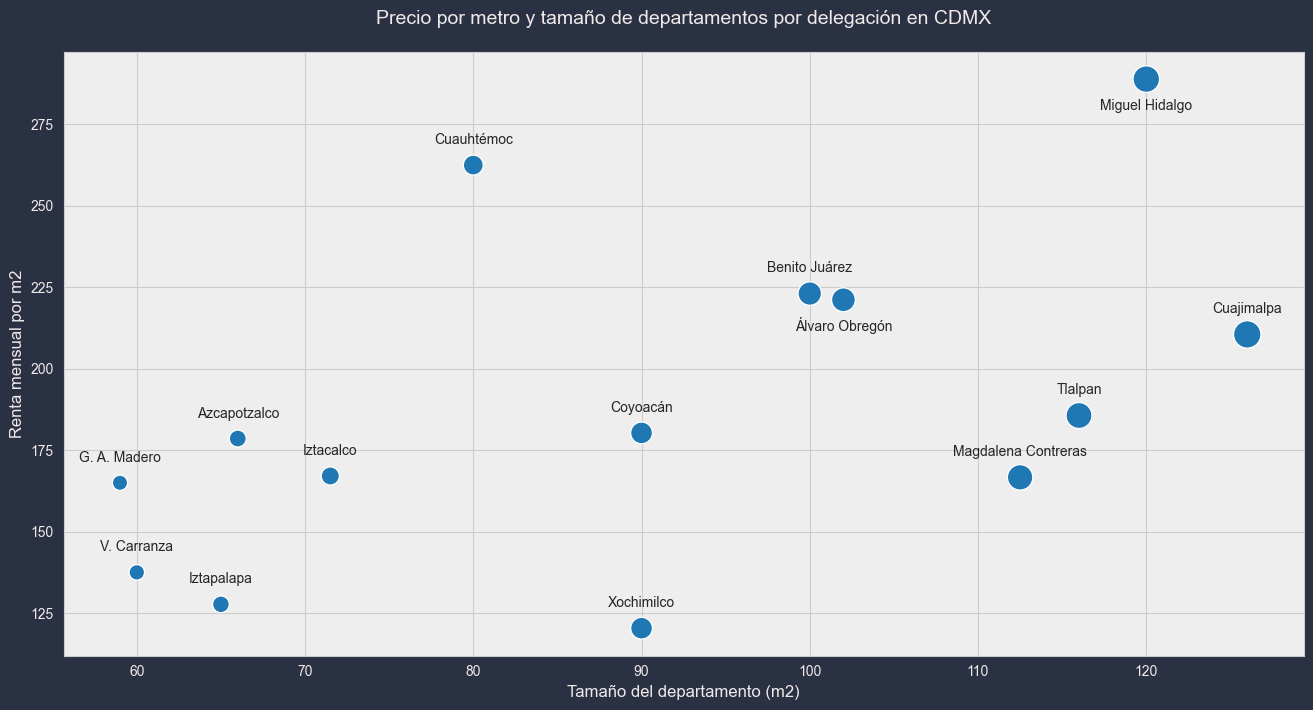

In [74]:
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=precios_sizes, x='size1', y='precio', size='size2', sizes=(min(precios_sizes.precio),max(precios_sizes.precio)+100))
ax.get_legend().remove()
ax.set_ylabel('Renta mensual por m2',fontsize=12)
ax.set_xlabel('Tamaño del departamento (m2)',fontsize=12)
for delegacion in arriba:
    ax.annotate(delegacion, (precios_sizes.loc[delegacion].size1,precios_sizes.loc[delegacion].precio+6.5),ha='center', fontsize=10)

for delegacion in abajo:
    ax.annotate(delegacion, (precios_sizes.loc[delegacion].size1,precios_sizes.loc[delegacion].precio-9.5),ha='center', fontsize=10)

ax.annotate('G. A. Madero', (precios_sizes.loc['Gustavo A. Madero'].size1,precios_sizes.loc['Gustavo A. Madero'].precio+6.5),ha='center', fontsize=10)
ax.annotate('V. Carranza', (precios_sizes.loc['Venustiano Carranza'].size1,precios_sizes.loc['Venustiano Carranza'].precio+6.5),ha='center', fontsize=10)
ax.set_title('Precio por metro y tamaño de departamentos por delegación en CDMX', pad=20, fontsize=14)
plt.savefig(r'C:\Users\omarp\Documents\Proyectos\Portafolios\images2\precio_vs_espacio.png', bbox_inches='tight')

plt.show()

In [ ]:
arriba = precios_sizes

Ahora, examinaremos una métrica nueva. Tomaremos el precio medio de la venta de inmuebles. Eso, lo dividiremos entre el precio medio de la renta, para poder obtener una idea de qué porcentaje del valor del inmueble representa la renta.

In [12]:
a = venta.groupby(['delegacion', 'category']).price.median()
b = renta.groupby(['delegacion','category']).price.median()
renta_venta = pd.DataFrame((pd.DataFrame(b/a)*100).to_records())

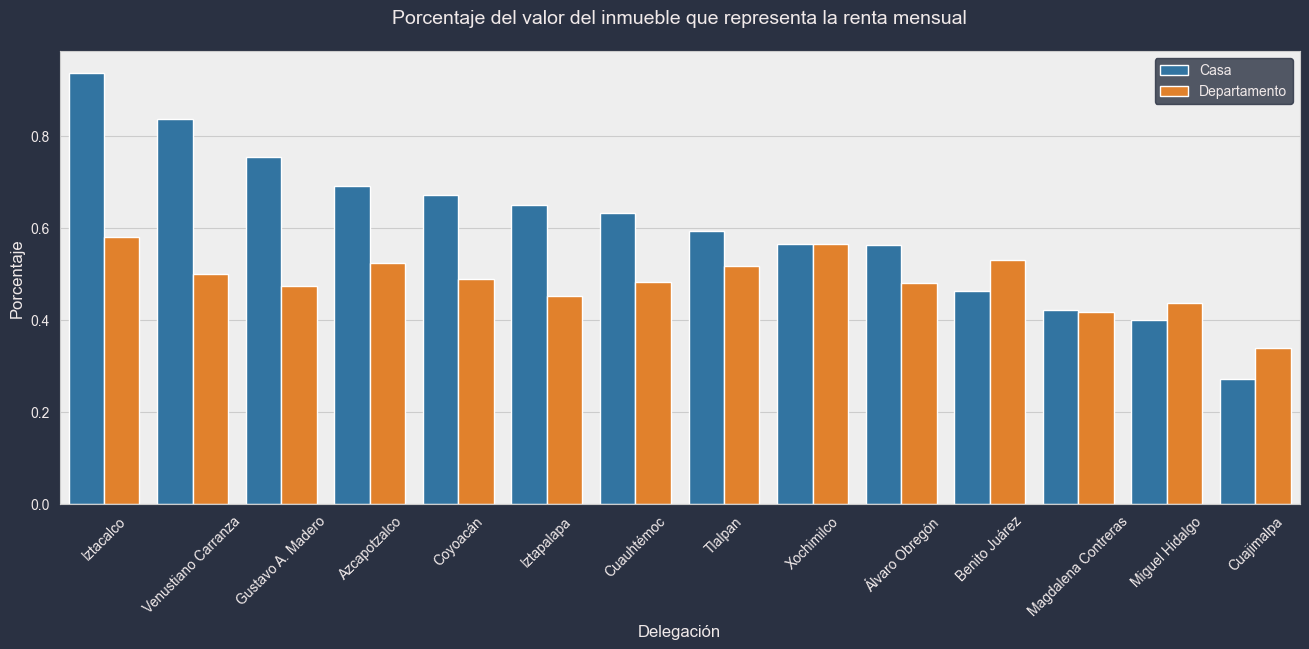

In [57]:
fig, ax = plt.subplots(figsize=(16,6))
order = renta_venta[renta_venta.category=='casa'].sort_values('price', ascending=False).delegacion
sns.barplot(data=renta_venta, x='delegacion', y='price', hue='category', ax=ax, order=order)
ax.set_xlabel('Delegación', fontsize=12)
ax.set_ylabel('Porcentaje', fontsize=12)
ax.set_title('Porcentaje del valor del inmueble que representa la renta mensual', fontsize=14, pad=20)
ax.legend([ax.patches[0], ax.patches[20]],['Casa', 'Departamento'],title=None, labelcolor='#F0E9E9')
plt.xticks(rotation=45)
plt.savefig(r'C:\Users\omarp\Documents\Proyectos\Portafolios\images2\porcentaje_renta.png', bbox_inches='tight')


plt.show()

In [84]:
precio_medio = pd.DataFrame(pd.DataFrame(datos.groupby(['delegacion', 'category']).price.median()).to_records())
comparacion_porcentaje = pd.merge(precio_medio, renta_venta, on=['delegacion', 'category'])
comparacion_porcentaje.rename(columns={'price_x':'precio', 'price_y':'porcentaje'}, inplace=True)

In [96]:
comparacion_porcentaje

,delegacion,category,precio,porcentaje
0,Azcapotzalco,casa,3390000.0,0.691511
1,Azcapotzalco,departamento,2250000.0,0.524254
2,Benito Juárez,casa,7350000.0,0.463659
3,Benito Juárez,departamento,3950000.0,0.530120
4,Coyoacán,casa,5850000.0,0.670391
5,Coyoacán,departamento,3125353.0,0.489934
6,Cuajimalpa,casa,8445000.0,0.272727
7,Cuajimalpa,departamento,4700000.0,0.338346
8,Cuauhtémoc,casa,7200000.0,0.633157
9,Cuauhtémoc,departamento,4178561.0,0.481351


In [97]:
renta.groupby(['delegacion', 'category']).price.median()

delegacion           category    
Azcapotzalco         casa            25000.0
                     departamento    12000.0
Benito Juárez        casa            37000.0
                     departamento    22000.0
Coyoacán             casa            42000.0
                     departamento    16500.0
Cuajimalpa           casa            30000.0
                     departamento    27000.0
Cuauhtémoc           casa            49000.0
                     departamento    22500.0
Gustavo A. Madero    casa            25000.0
                     departamento    11000.0
Iztacalco            casa            23000.0
                     departamento    11150.0
Iztapalapa           casa            18500.0
                     departamento     8100.0
Magdalena Contreras  casa            35000.0
                     departamento    19600.0
Miguel Hidalgo       casa            71250.0
                     departamento    35000.0
Tlalpan              casa            35000.0
                     

In [100]:
23000*(1.05)**10

37464.576415881165

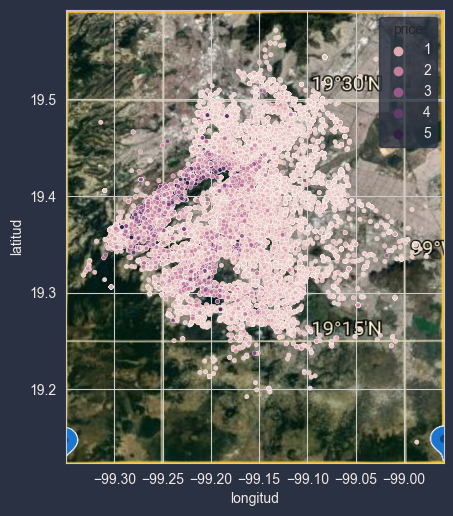

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x='longitud', y='latitud', hue='price', data= datos[datos.operacion=='venta'], linewidths=0.5, ax=ax, s=10)
ax.imshow(plt.imread('pruebamapa.jpg'),extent=[-99.34954739, -98.95910481, 19.12385016601, 19.59284683019])

In [15]:
rd = renta[renta.category=='departamento'].copy()
rd.loc[:,'precio_cuarto'] = rd.apply(lambda row: row.price/row.bedrooms if row.bedrooms != 0 else row.price, axis=1)

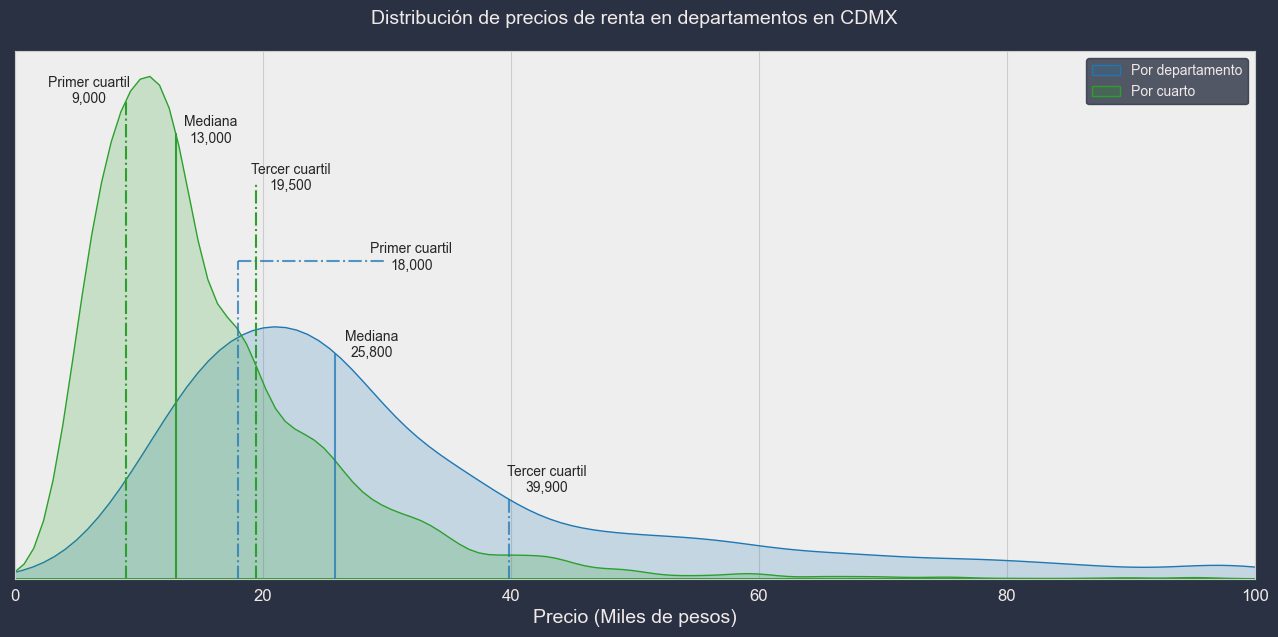

In [23]:
mediana = renta[renta.category=='departamento'].price.median()
q1 = np.quantile(renta[renta.category=='departamento'].price, 0.25)
q3 = np.quantile(renta[renta.category=='departamento'].price, 0.75)
promedio = renta[renta.category=='departamento'].price.mean()
color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.75)
fig, ax = plt.subplots(figsize=(16,6))

sns.kdeplot(x=renta[renta.category=='departamento'].price, fill=True, ax=ax, alpha=0.2, label='Por departamento')
ax.xaxis.set_major_formatter(formatter2)
ax.set_title('Distribución de precios de renta en departamentos en CDMX',pad=20, fontsize=14)
plt.xticks(fontsize=12)
ax.plot((mediana,mediana), (0,0.0000283), '-', c=color)
ax.plot((q1,q1), (0,0.00004), '-.', c=color)
ax.plot((q1,q1+12000), (0.00004,0.00004), '-.', c=color)
ax.plot((q3,q3), (0,0.000010), '-.', c=color)
ax.annotate('Primer cuartil\n18,000',(q1+14000,0.000039),horizontalalignment='center')
ax.annotate('Mediana\n25,800',(mediana+3000,0.000028),horizontalalignment='center')
ax.annotate('Tercer cuartil\n39,900',(q3+3000,0.000011),horizontalalignment='center')

mediana = rd.precio_cuarto.median()
q1 = np.quantile(rd.precio_cuarto, 0.25)
q3 = np.quantile(rd.precio_cuarto, 0.75)

color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
sns.kdeplot(x=rd.precio_cuarto, fill=True, color=color, ax=ax, alpha=0.2, label='Por cuarto')
ax.set_xlim((0,100000))
ax.xaxis.set_major_formatter(formatter2)
ax.get_yaxis().set_ticks([])
ax.set_ylabel('')

ax.set_xlabel('Precio (Miles de pesos)', fontsize=14)
plt.xticks(fontsize=12)
ax.plot((mediana,mediana), (0,0.000056), '-', c=color)
ax.plot((q1,q1), (0,0.00006), '-.', c=color)
ax.plot((q3,q3), (0,0.00005), '-.', c=color)
ax.annotate('Primer cuartil\n9,000',(q1-3000,0.00006),horizontalalignment='center')
ax.annotate('Mediana\n13,000',(mediana+2800,0.000055),horizontalalignment='center')
ax.annotate('Tercer cuartil\n19,500',(q3+2800,0.000049),horizontalalignment='center')
plt.legend()
plt.subplots_adjust(bottom=0.001, wspace=None, hspace=None)
plt.savefig(r'C:\Users\omarp\Documents\Proyectos\Portafolios\images2\distribucion_renta.png', bbox_inches='tight')



plt.show()

In [407]:
sns.color_palette()[2]

(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)

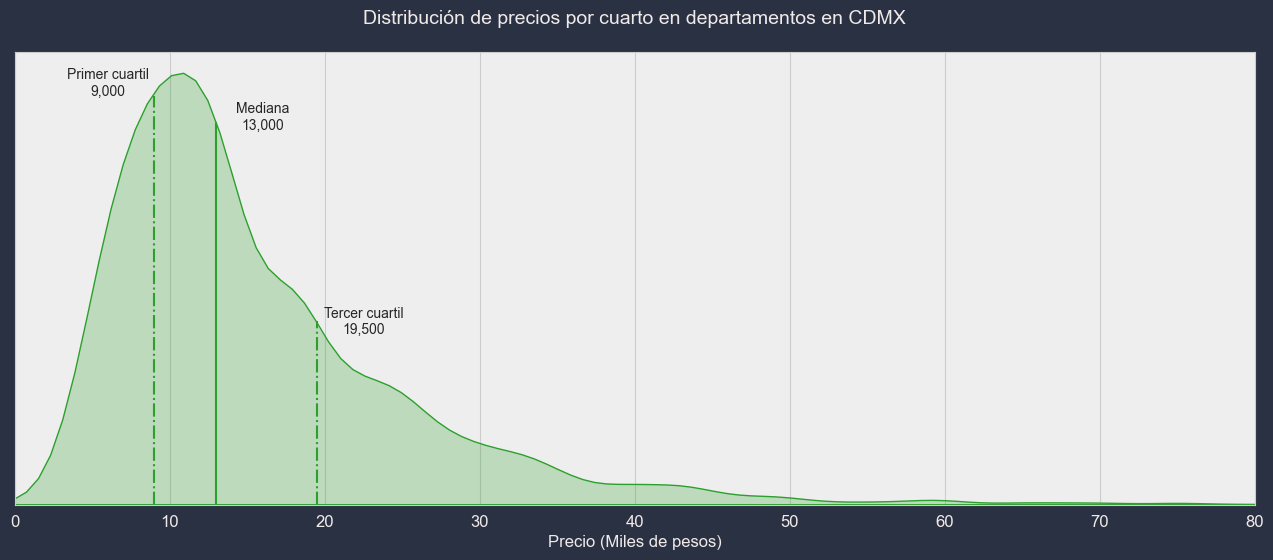

In [452]:
mediana = rd.precio_cuarto.median()
q1 = np.quantile(rd.precio_cuarto, 0.25)
q3 = np.quantile(rd.precio_cuarto, 0.75)

color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
fig, ax = plt.subplots(figsize=(16,6))
ax = sns.kdeplot(x=rd.precio_cuarto, fill=True, color=color)
ax.set_xlim((0,80000))
ax.xaxis.set_major_formatter(formatter2)
ax.get_yaxis().set_ticks([])
ax.set_ylabel('')
ax.set_title('Distribución de precios por cuarto en departamentos en CDMX',pad=20, fontsize=14)
ax.set_xlabel('Precio (Miles de pesos)', fontsize=12)
plt.xticks(fontsize=12)
ax.plot((mediana,mediana), (0,0.000056), '-', c=color)
ax.plot((q1,q1), (0,0.00006), '-.', c=color)
ax.plot((q3,q3), (0,0.000027), '-.', c=color)
ax.annotate('Primer cuartil\n9,000',(q1-3000,0.00006),horizontalalignment='center')
ax.annotate('Mediana\n13,000',(mediana+3000,0.000055),horizontalalignment='center')
ax.annotate('Tercer cuartil\n19,500',(q3+3000,0.000025),horizontalalignment='center')
plt.savefig(r'C:\Users\omarp\Documents\Proyectos\Portafolios\images2\precio_cuarto.png', bbox_inches='tight')

plt.show()

In [209]:
renta.groupby(['delegacion', 'category']).price.median()

delegacion           category    
Azcapotzalco         casa            25000.0
                     departamento    12000.0
Benito Juárez        casa            37000.0
                     departamento    22000.0
Coyoacán             casa            42000.0
                     departamento    16500.0
Cuajimalpa           casa            30000.0
                     departamento    27000.0
Cuauhtémoc           casa            49000.0
                     departamento    22500.0
Gustavo A. Madero    casa            25000.0
                     departamento    11000.0
Iztacalco            casa            23000.0
                     departamento    11150.0
Iztapalapa           casa            18500.0
                     departamento     8100.0
Magdalena Contreras  casa            35000.0
                     departamento    19600.0
Miguel Hidalgo       casa            71250.0
                     departamento    35000.0
Tlalpan              casa            35000.0
                     

## Modelado

In [101]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor as kn
from sklearn import model_selection

### Modelado de la venta

In [157]:
variables = ['category', 'bedrooms', 'bathrooms', 'building_size', 'delegacion','longitud', 'latitud']
X = venta[variables]
y = venta['price']
neighbors = kn(n_neighbors = 2, weights='distance')
X = pd.get_dummies(X)

In [158]:
scaler = preprocessing.MinMaxScaler()
y = np.array(y).reshape(-1,1)
X = scaler.fit_transform(X)

In [183]:
scores = []

In [184]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2)
for k in range(1,51):
    neighbors = kn(n_neighbors = k, weights='distance')
    neighbors.fit(x_train, y_train)
    scores.append(neighbors.score(x_test, y_test))

### Modelado de la renta

In [189]:
variables = ['category', 'bedrooms', 'bathrooms', 'building_size', 'delegacion','longitud', 'latitud']
Xrenta = renta[variables]
yrenta = renta['price']
Xrenta = pd.get_dummies(Xrenta)

In [190]:
scaler = preprocessing.MinMaxScaler()
yrenta = np.array(y).reshape(-1,1)
Xrenta = scaler.fit_transform(X)

In [191]:
scores_renta = []

In [192]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(Xrenta,yrenta,test_size=0.2)
for k in range(1,51):
    neighbors = kn(n_neighbors = k, weights='distance')
    neighbors.fit(x_train, y_train)
    scores_renta.append(neighbors.score(x_test, y_test))

### Graficar

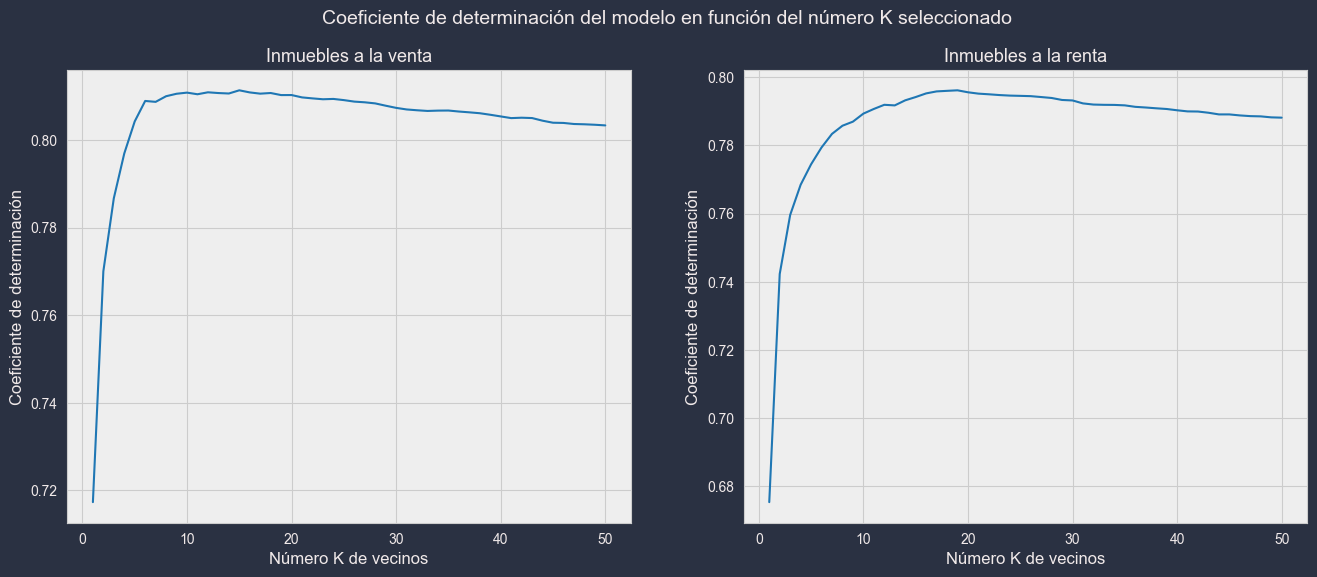

In [198]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(16,6))
ax.plot(range(1,51), scores, '-')
ax.set_title('Inmuebles a la venta', fontsize=13)
ax.set_ylabel('Coeficiente de determinación', fontsize=12)
ax.set_xlabel('Número K de vecinos', fontsize=12)

ax2.plot(range(1,51), scores_renta, '-')
ax2.set_title('Inmuebles a la renta', fontsize=13)
ax2.set_ylabel('Coeficiente de determinación', fontsize=12)
ax2.set_xlabel('Número K de vecinos', fontsize=12)
fig.suptitle('Coeficiente de determinación del modelo en función del número K seleccionado', c='#F0E9E9', fontsize=14)
plt.savefig(r'C:\Users\omarp\Documents\Proyectos\Portafolios\images2\modelo_resultados.png', bbox_inches='tight')

plt.show()

In [200]:
max(scores)

0.8113827318647043

In [205]:
15

15

In [207]:
max(scores_renta)

0.79618689033327

In [208]:
19

19